## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, compute the camera calibration using chessboard images

err_count:3


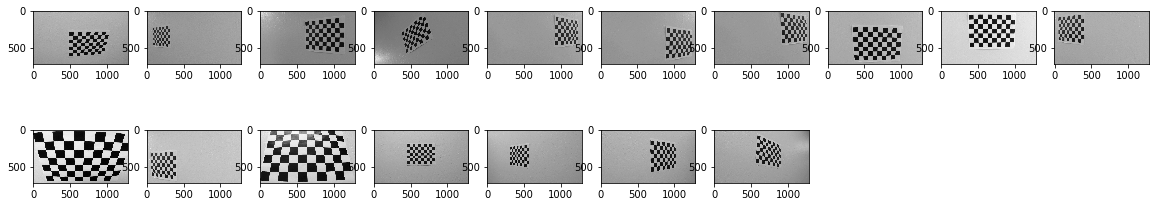

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

imgSize = (0,0)

# display calibration images
cols = 10
rows = 2
plt.figure(figsize=(cols * 2, rows * 2))
i = 0
err_count = 0


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        if imgSize == (0,0):
            imgSize = gray.shape[::-1]

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        plt.subplot(rows,cols,i+1)
        plt.imshow(gray.squeeze(), cmap="gray")
        i += 1
    else:
        err_count += 1

print("err_count:{}".format(err_count))

## Get Matrix and other variables from Camera Calibration

In [2]:
# calibrate camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imgSize, None, None)

## Utility function to get an undistroted image based on camera calibraion

In [3]:
# get an undistorted image based on matrix from camera calibration
def get_undistorted_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

In [4]:
# utility to show two images side by side
# Plot the result
def plot2(image1, title1, image2, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=40)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def plot3(image1, title1, image2, title2, plot3, title3):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(image2)
    ax2.set_title(title2, fontsize=50)
    ax3.plot(plot3)
    ax3.set_title(title3, fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    

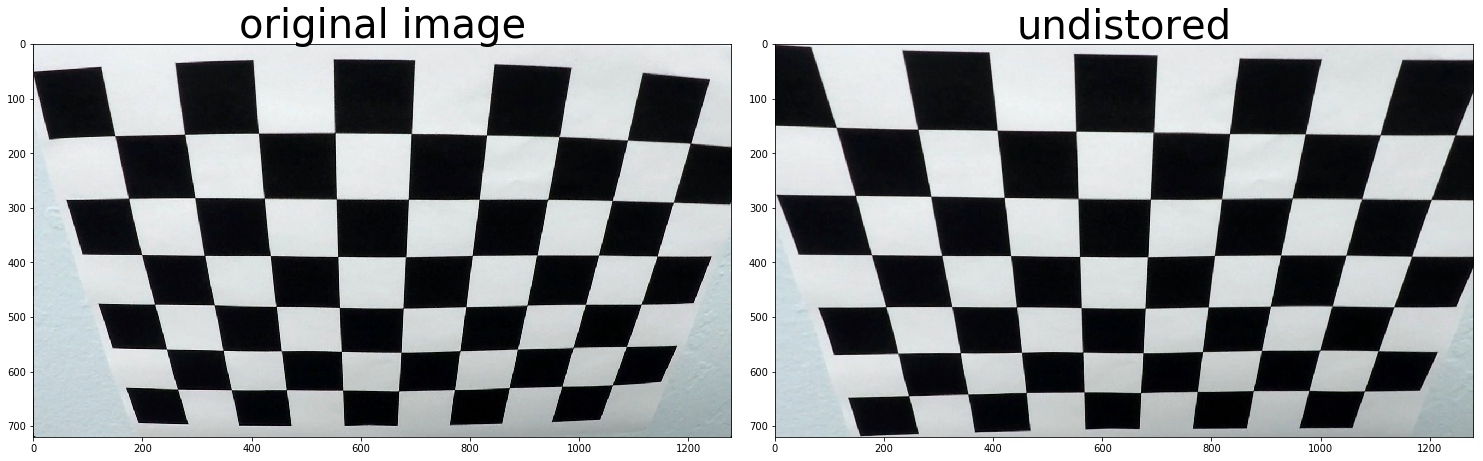

In [5]:
# Apply a distortion correction to raw images.
%matplotlib inline
# read a test image
test_file = 'camera_cal/calibration2.jpg'
img1 = cv2.imread(test_file)
dst1 = get_undistorted_image(img1)
plot2(img1, 'original image', dst1, 'undistored')

In [141]:
# apply color and sobel gradient 
def pipeline(img1, s_thresh=(180, 255), sx_thresh=(80, 255), mag_thresh=(50,255), theda_thresh=(0, np.pi/2), l_thresh=(215,255), b_thresh=(145,200)):
    img = np.copy(img1)
    sobel_kernel=3
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <= b_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * mag / np.max(mag)) 
    mag_binary = np.zeros_like(scaled_mag)
    mag_binary[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
     
    # 5) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    theda = np.arctan2(abs_sobely, abs_sobelx)
    theda_binary = np.zeros_like(theda)
    theda_binary[(theda >= theda_thresh[0]) & (theda <= theda_thresh[1])] = 1
    
    # combine all
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (sx_binary == 1)  | ((mag_binary == 1) & (theda_binary == 1))] = 1
    
    return combined_binary

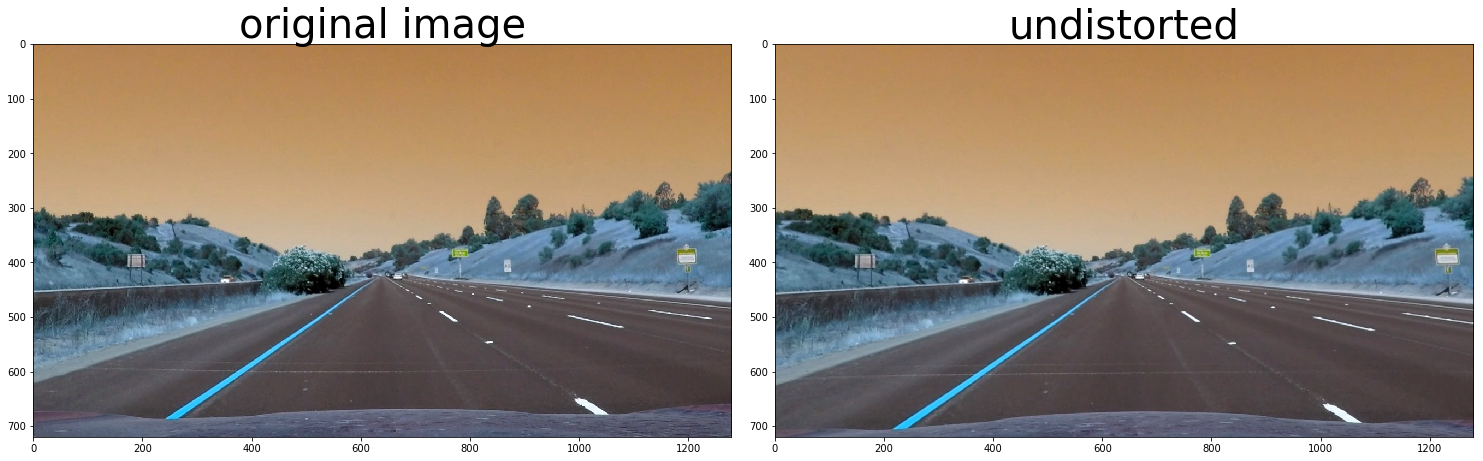

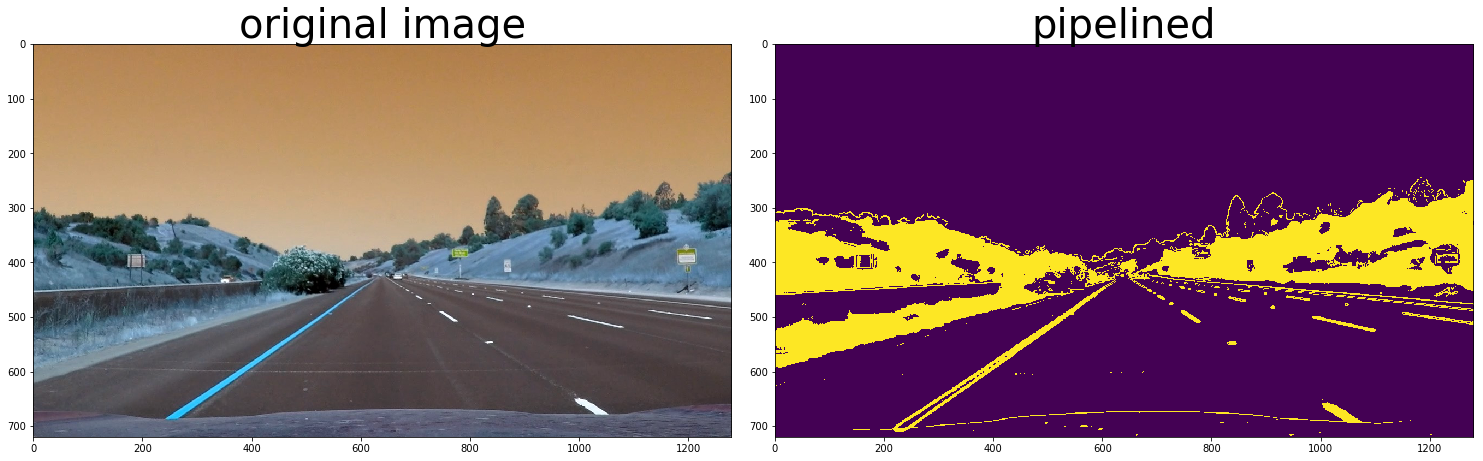

In [142]:
test_file = 'test_images/straight_lines1.jpg'
img1 = cv2.imread(test_file)
dst1 = get_undistorted_image(img1)
output = pipeline(dst1)
plot2(img1, 'original image', dst1, 'undistorted')
plot2(img1, 'original image', output, 'pipelined')

In [131]:
# apply PerspectiveTransform
def apply_persepctive_transform(img, src_corners):
    width =  img.shape[1]
    height = img.shape[0]
    #dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720], [40, 720]])
    M = cv2.getPerspectiveTransform(src_corners, dst)
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

(720, 1280)


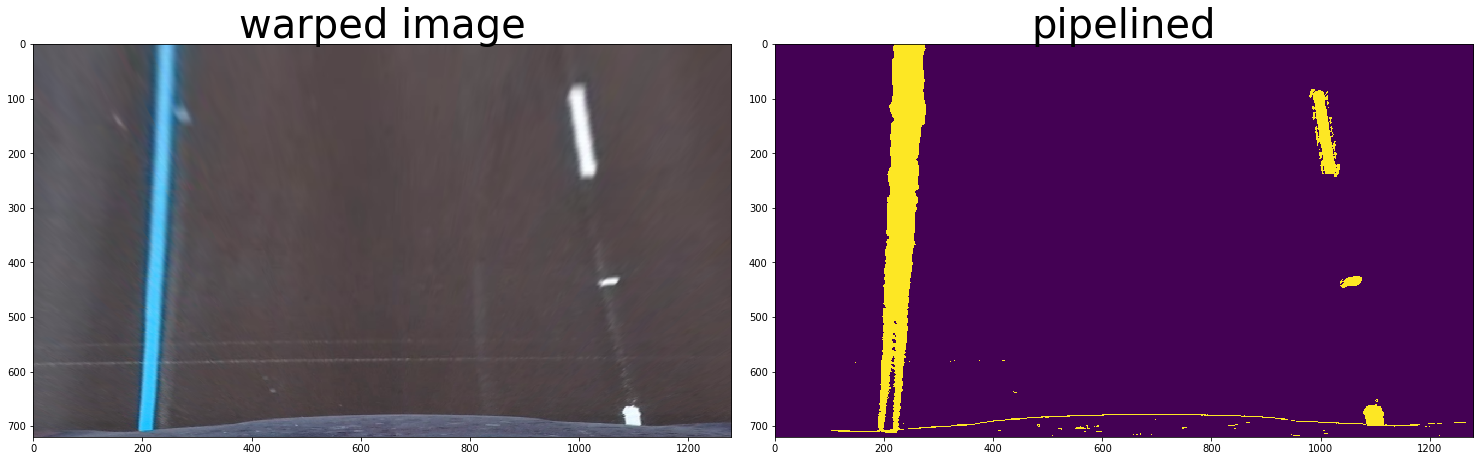

In [143]:
# test perspective transform
print(output.shape)
#src_corners = np.float32([[490, 480], [810,  480], [1250, 720], [40, 720]])
src_corners = np.float32([[490, 482], [810,  482], [1250, 720], [40, 720]])
warped_img = apply_persepctive_transform(dst1, src_corners)
output2 = pipeline(warped_img)
plot2(warped_img, 'warped image', output2, 'pipelined')

In [144]:
# uitility to tranform images from un-distorted, perspective tranform, and pipeline 
def apply_transforms(image):
    # 1. make the image undistored
    dst1 = get_undistorted_image(image)
    src_corners = np.float32([[490, 480], [810,  480], [1250, 720], [40, 720]])
    # 2. apply perspective transform
    warped = apply_persepctive_transform(dst1, src_corners)
    # 3. apply pipeline with gradient and color threshold
    return pipeline(warped)

In [145]:
# uitility to tranform images from un-distorted, perspective tranform, and pipeline 
def apply_transforms_no_pipeline(image):
    # 1. make the image undistored
    dst1 = get_undistorted_image(image)
    src_corners = np.float32([[490, 480], [810,  480], [1250, 720], [40, 720]])
    # 2. apply perspective transform
    warped = apply_persepctive_transform(dst1, src_corners)
    return warped

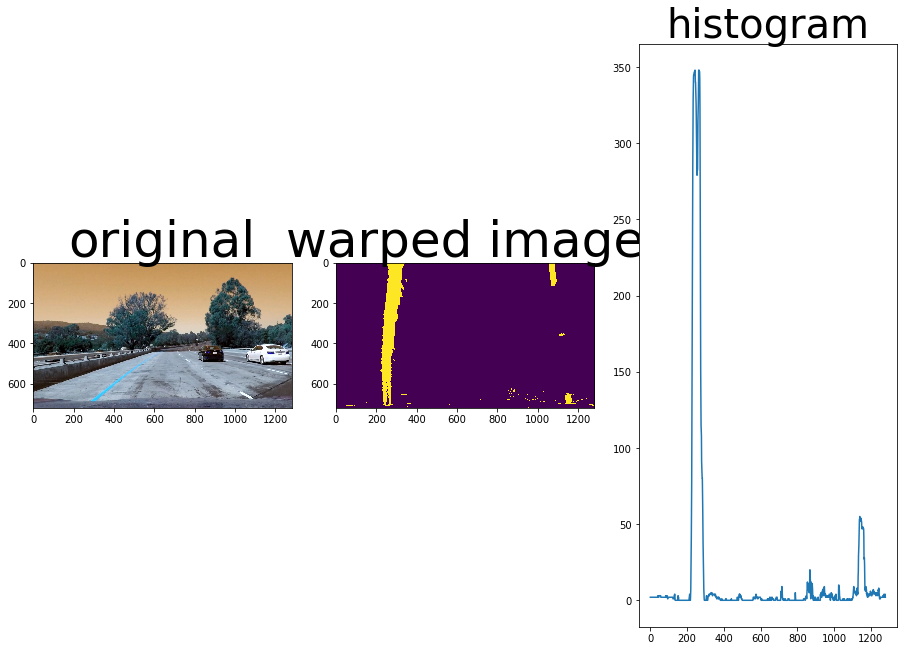

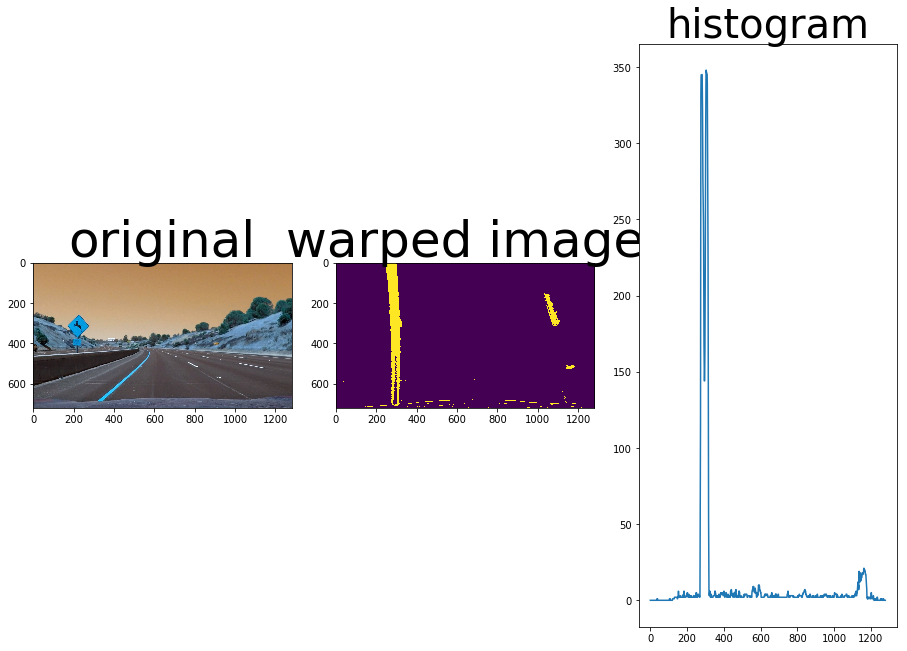

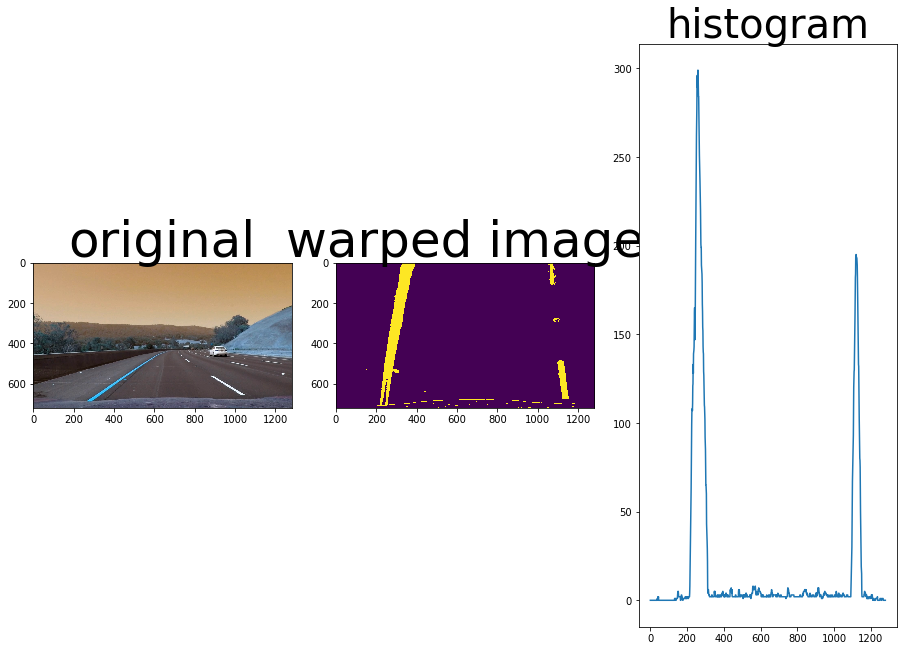

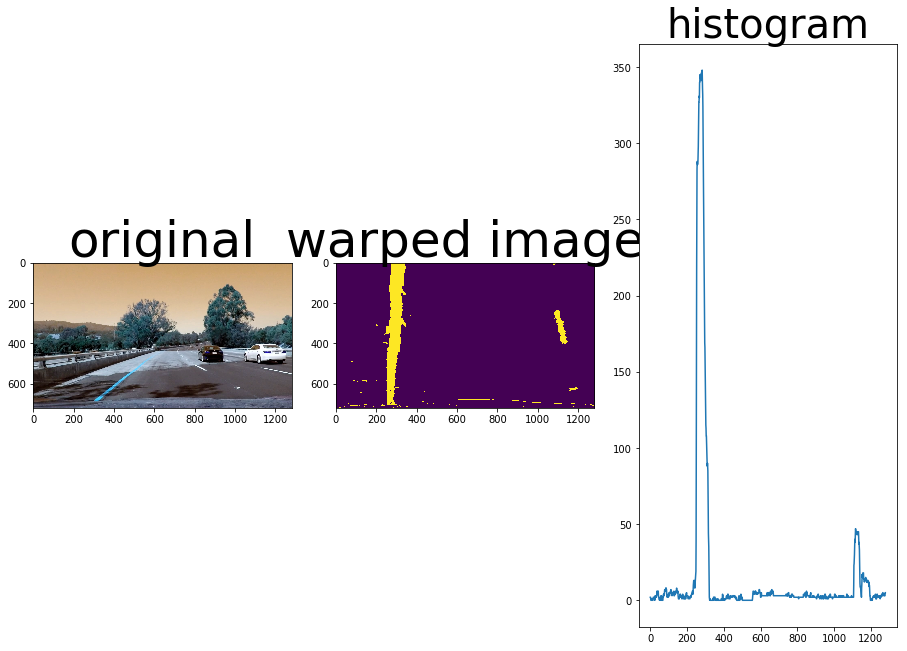

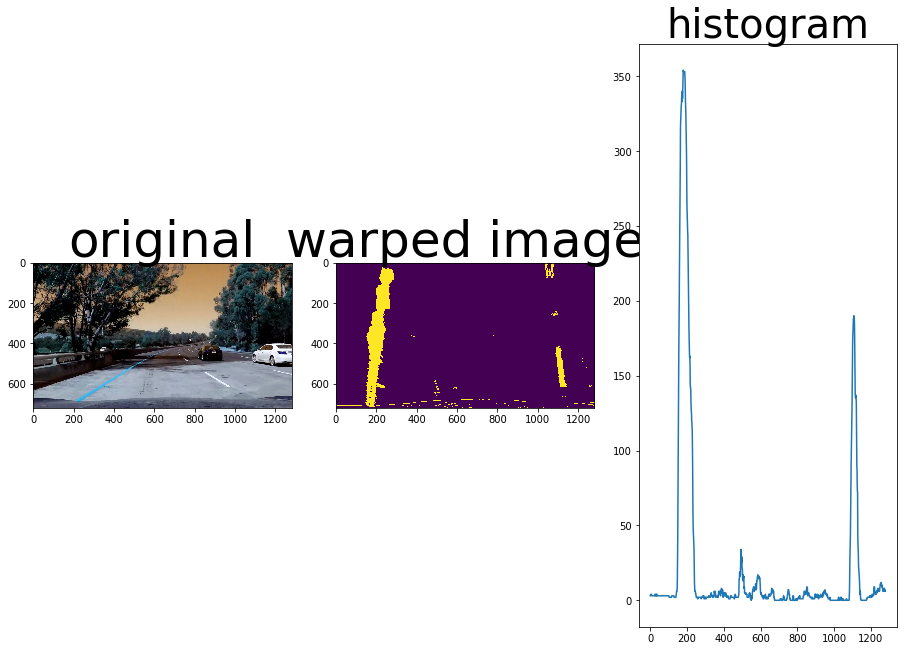

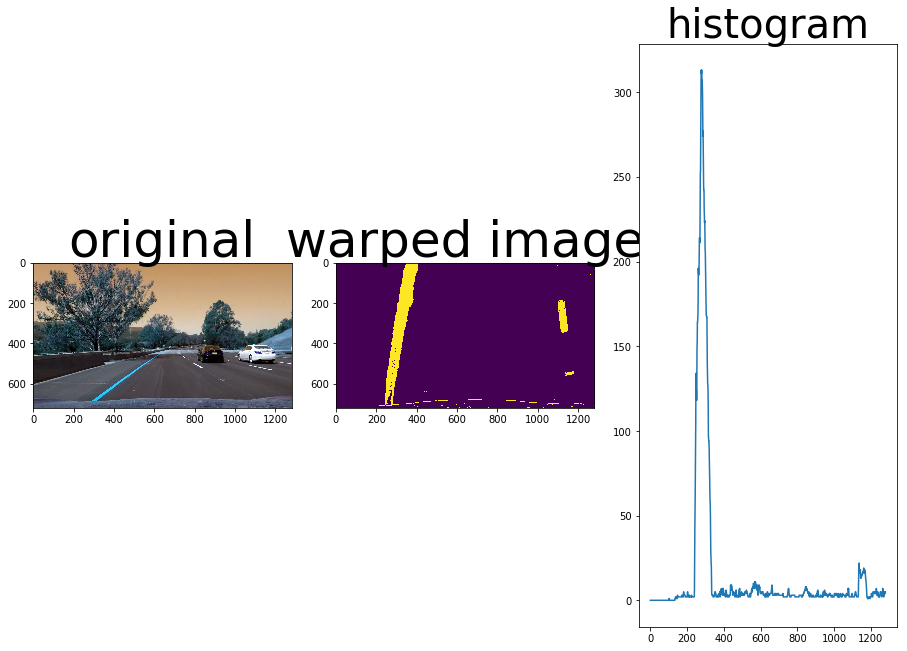

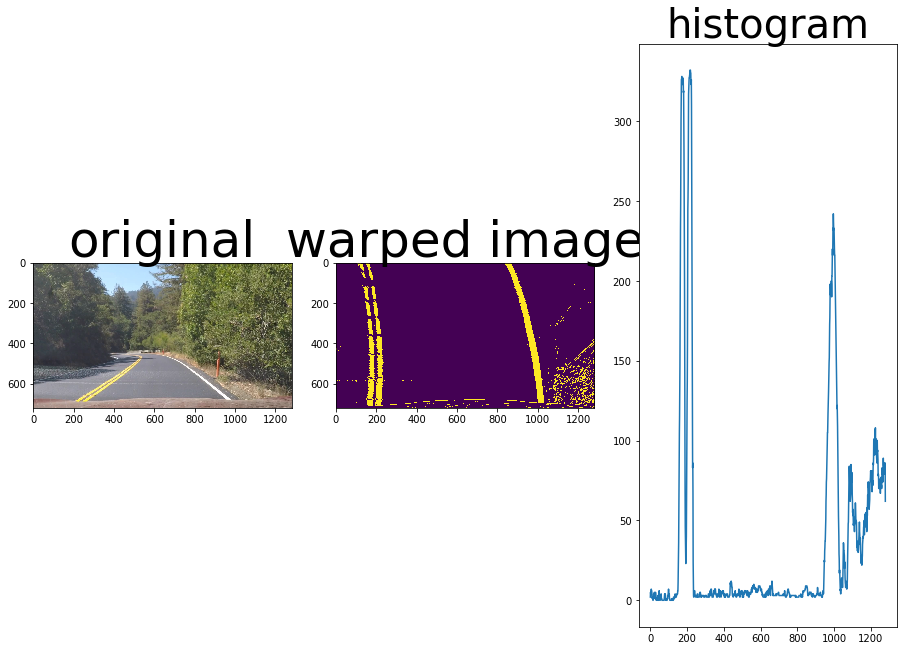

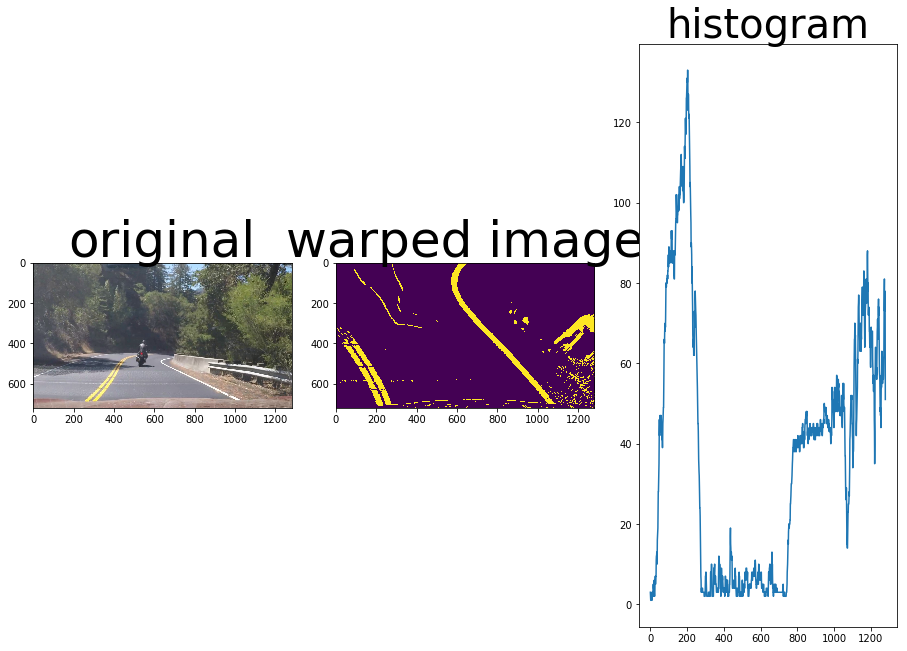

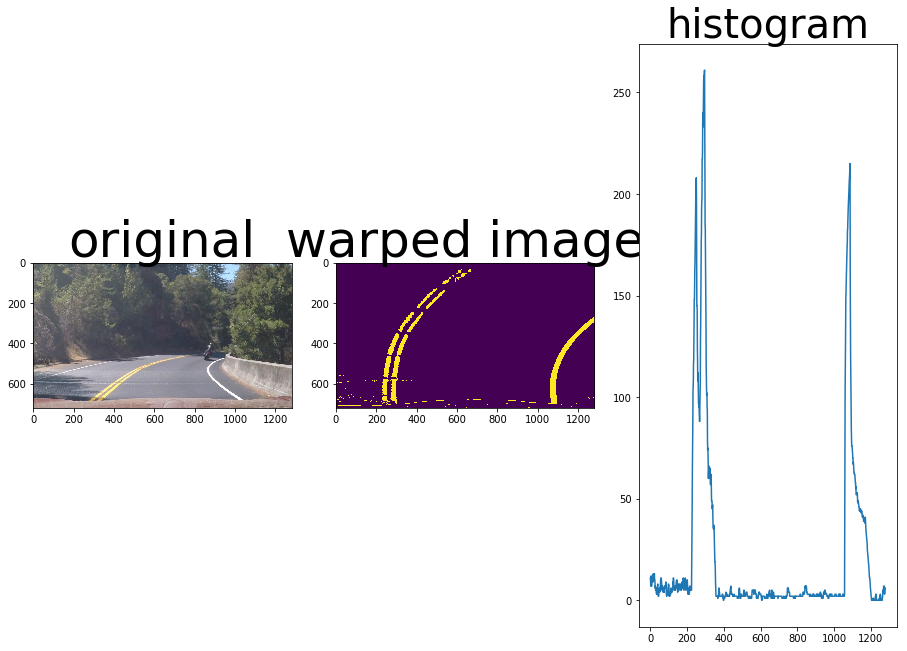

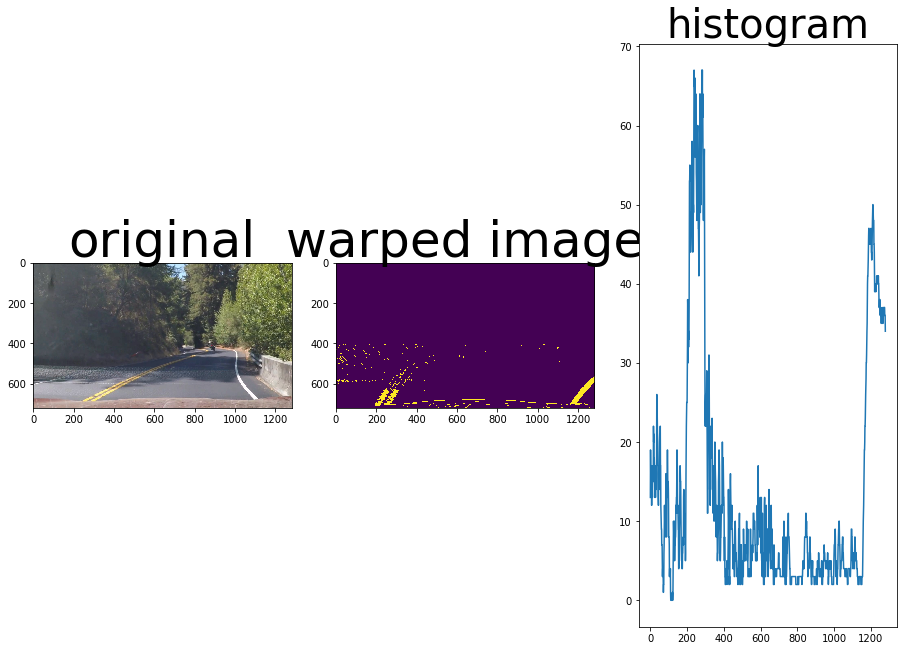

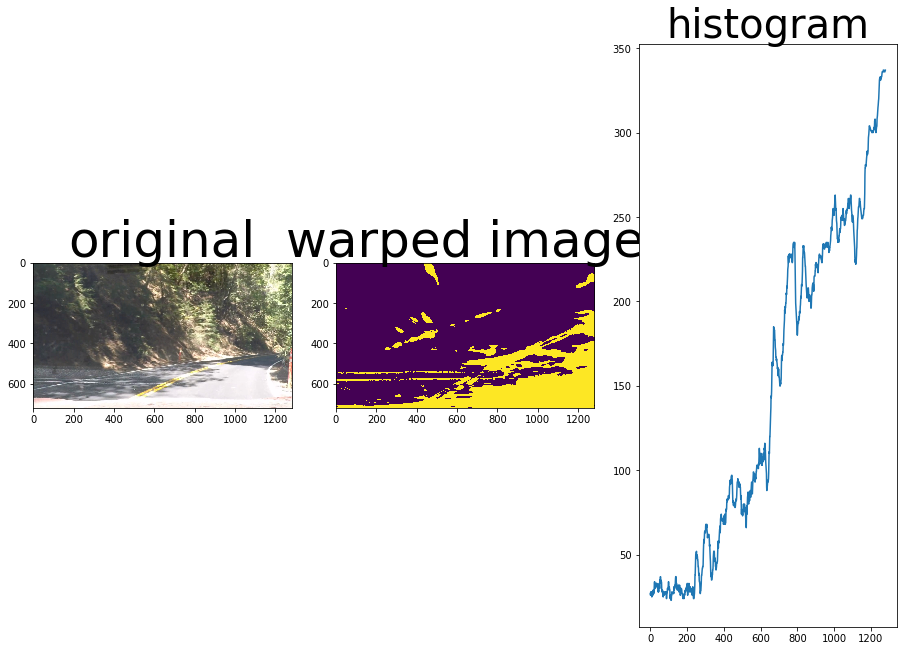

In [146]:
for image in glob.glob('test_images/test*.jpg'):
    img1 = cv2.imread(image)
    warped = apply_transforms(img1)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    plot3(img1, 'original', warped, 'warped image', histogram, 'histogram' )

In [147]:
# measuring curvature
def measure_curvature(leftx, lefty, rightx, righty):
    
    # define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*np.max(lefty)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

In [158]:

# Fill lane for the image
def fill_lane (img1, plot=True, dbg_frame_idx=0):
    # apply transforms first
    warped = apply_transforms(img1)
    
    # use histogram to look for left and right lanes
    delta = 90
    i = 720
    j = 630
    pivotx = 640
    leftx = []
    lefty = []
    rightx = []
    righty = []

    x, y = np.nonzero(np.transpose(warped))
    #print("x len={}, y len={}".format(len(x), len(y)))
    dbg_count = 0
    dbg_list = []
    abs_peak_left = -1
    abs_peak_right = -1
    while j >= 0:
        hist = np.sum(warped[j:i,:], axis=0)
        peak_left = np.argmax(hist[:pivotx])
        if abs_peak_left == -1:
            abs_peak_left = peak_left
        x_idx = np.where((x > (peak_left - 25)) & (x < (peak_left + 25)) & (y > j) & (y < i))
        if np.sum(x[x_idx]) != 0:
            leftx.extend(x[x_idx].tolist())
            lefty.extend(y[x_idx].tolist())
            
        peak_right = np.argmax(hist[pivotx:]) + pivotx
        if (abs_peak_right == -1):
            abs_peak_right = peak_right
        if (dbg_count < 5):
            dbg_list.append(peak_right)
            dbg_count += 1
        x_idx = np.where((x > (peak_right - 25)) & (x < (peak_right + 25)) & (y > j) & (y < i))
        if np.sum(x[x_idx]) != 0:
            rightx.extend(x[x_idx].tolist())
            righty.extend(y[x_idx].tolist())
        i -= delta
        j -= delta
    
    # check valid data points to proceed
    if len(leftx) == 0 or len(rightx) == 0:
        print("Got dbg_frame_idx:{}, len(leftx):{}, len(rightx):{}".format(dbg_frame_idx, len(leftx), len(rightx)))
        name = "dbg_frame_" + str(dbg_frame_idx) + ".jpg"
        cv2.imwrite(name, img1)
        dbg_frame_idx += 1
        return img1
    
    #print("peak_right:{}".format(peak_right))    
    leftx = np.array(leftx).astype(np.float32)
    lefty = np.array(lefty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)   
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_x = left_fit[0] * lefty**2 + left_fit[1] * lefty + left_fit[2]
    leftx_int = left_fit[0] * 720**2 + left_fit[1] * 720 + left_fit[2]
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_fit[2])
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    leftx = leftx[lsort]
    lefty = lefty[lsort]
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fit_x = left_fit[0] * lefty**2 + left_fit[1] * lefty + left_fit[2]
    
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_x = right_fit[0] * righty**2 + right_fit[1] * righty + right_fit[2]
    #rightx_int = right_fit[0] * 720**2 + right_fit[1]*720 + right_fit[2]
    rightx_int = abs_peak_right
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_fit[2])
    righty = np.append(righty, 0)
    rsort = np.argsort(righty)
    rightx = rightx[rsort]
    righty = righty[rsort]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fit_x = right_fit[0] * righty**2 + right_fit[1] * righty + right_fit[2]
    #print("peak_right:{}, rightx_int:{}, peak_left:{}, leftx_int:{}".format(peak_right, rightx_int, peak_left, leftx_int))
    
    # calculate vehicle pos
    pos = (rightx_int+leftx_int)/2
    distance_from_center = abs((pivotx - pos)*3.7/700) 
    img_size = (warped.shape[1], warped.shape[0])
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fit_x, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fit_x, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness=35)
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    #dst = np.float32([[0, 0], [img_size[0], 0], [img_size[0], img_size[1]], [0, img_size[1]]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720], [40, 720]])
    M2 = cv2.getPerspectiveTransform(dst, src_corners)
    newWarp = cv2.warpPerspective(color_warp, M2, img_size)
    result = cv2.addWeighted(img1, 1, newWarp, 0.5, 0)
    
    # calculate curvatures
    left_curverad, right_curverad = measure_curvature(leftx, lefty, rightx, righty)
    if plot:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(apply_transforms_no_pipeline(img1))
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(0, 720)
        ax1.plot(left_fit_x, lefty, color='green', linewidth=5)
        ax1.plot(right_fit_x, righty, color='red', linewidth=5)
        ax1.set_title('Lane Lines', fontsize=16)
        ax1.invert_yaxis() # to visualize as we do the images
        # Print radius of curvature on image/video
        cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        ax2.imshow(result)
        ax2.set_title('Lane Fill', fontsize=16)
    else:
        if pos > 640:
            cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        else:
            cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
        cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((left_curverad+right_curverad)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(0,0,255), thickness = 2)
         
    return result

peak_right:1061, rightx_int:1143, peak_left:261, leftx_int:246.07731433619463
peak_right:640, rightx_int:1129, peak_left:254, leftx_int:292.1209568972733
peak_right:1058, rightx_int:1120, peak_left:327, leftx_int:223.9739463019351
peak_right:1074, rightx_int:1153, peak_left:276, leftx_int:268.5129999894315
peak_right:1041, rightx_int:852, peak_left:229, leftx_int:176.5875822630056
peak_right:1093, rightx_int:662, peak_left:346, leftx_int:248.4388696808015
peak_right:869, rightx_int:1010, peak_left:165, leftx_int:156.3894771132351
peak_right:640, rightx_int:1040, peak_left:599, leftx_int:173.88416880651664
peak_right:656, rightx_int:1068, peak_left:618, leftx_int:317.7351792806569
peak_right:640, rightx_int:1189, peak_left:0, leftx_int:277.72041893797467
peak_right:1261, rightx_int:679, peak_left:463, leftx_int:627.4367315720801
peak_right:640, rightx_int:1100, peak_left:230, leftx_int:209.25044141824452
peak_right:988, rightx_int:1099, peak_left:240, leftx_int:218.41783193988516
peak_r

array([[[ 64,  57,  48],
        [ 55,  46,  36],
        [ 57,  45,  33],
        ..., 
        [186, 182, 181],
        [208, 211, 215],
        [235, 241, 248]],

       [[ 61,  47,  29],
        [ 55,  40,  21],
        [100,  83,  62],
        ..., 
        [166, 153, 137],
        [173, 164, 155],
        [203, 197, 192]],

       [[ 65,  41,  11],
        [129, 106,  74],
        [186, 159, 125],
        ..., 
        [183, 155, 124],
        [181, 158, 132],
        [179, 158, 136]],

       ..., 
       [[ 64,  65,  75],
        [ 87,  87,  99],
        [ 88,  88, 100],
        ..., 
        [ 70,  77,  94],
        [ 82,  89, 106],
        [118, 125, 142]],

       [[ 54,  55,  65],
        [ 92,  92, 104],
        [ 95,  95, 107],
        ..., 
        [ 60,  64,  82],
        [ 79,  83, 101],
        [113, 118, 133]],

       [[ 23,  24,  34],
        [ 67,  68,  78],
        [100, 100, 112],
        ..., 
        [ 53,  57,  75],
        [ 96, 101, 116],
        [129, 134,

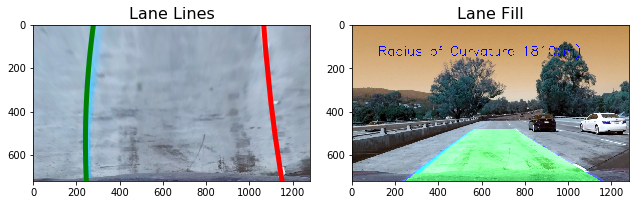

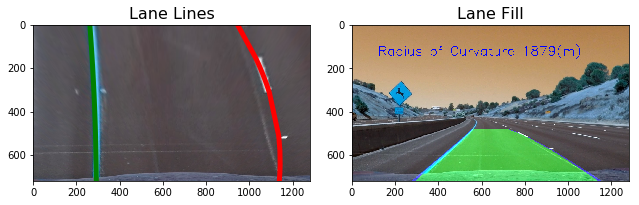

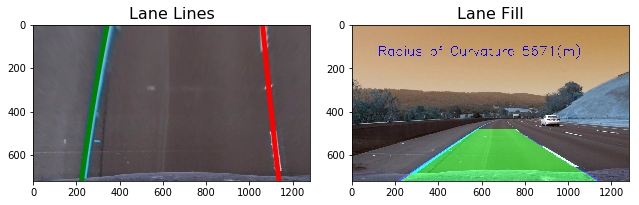

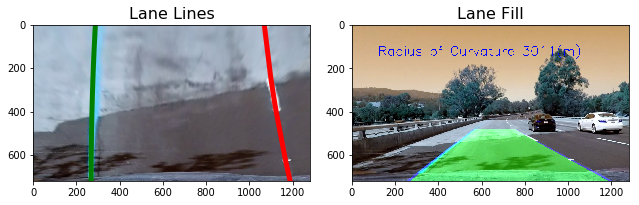

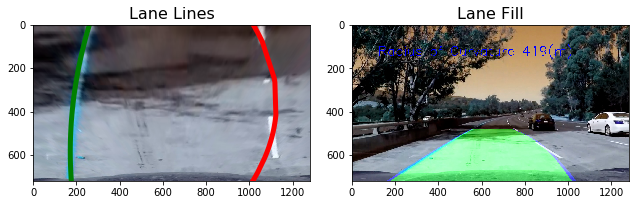

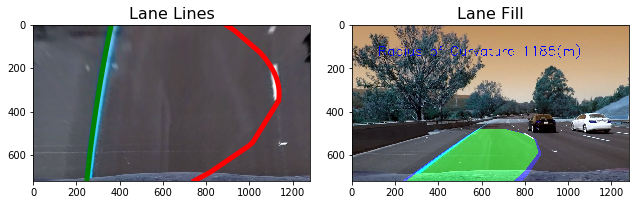

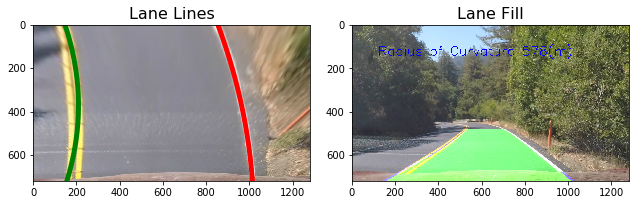

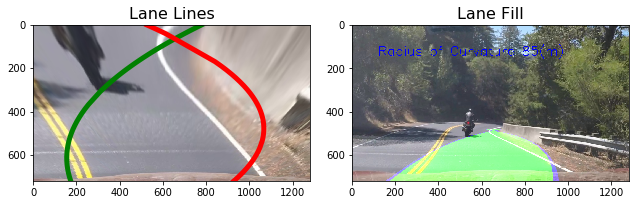

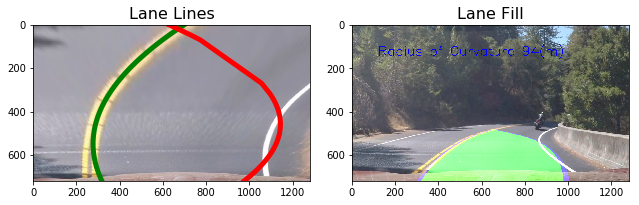

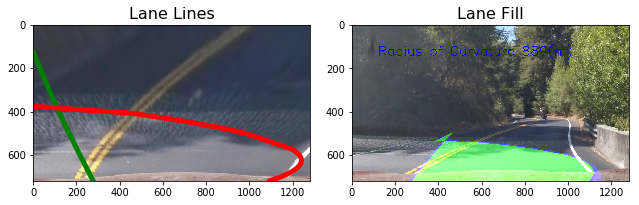

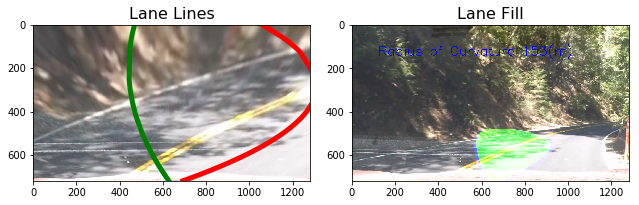

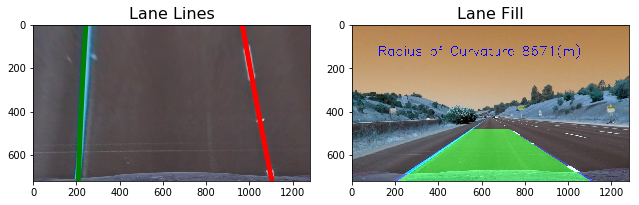

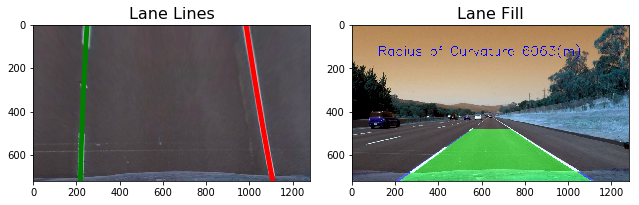

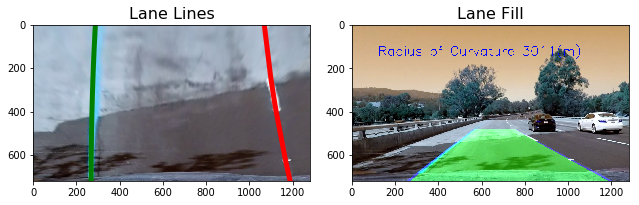

In [149]:
for image in glob.glob('test_images/test*.jpg'):
    img1 = cv2.imread(image)
    fill_lane(img1)
    
img1 = cv2.imread('test_images/straight_lines1.jpg')
fill_lane(img1)
img2 = cv2.imread('test_images/straight_lines2.jpg')
fill_lane(img2)
img2 = cv2.imread('test_images/test4.jpg')
fill_lane(img2)

In [150]:
def process_vid2(image):
    global dbg_frame_idx
    result = fill_lane(image, False, dbg_frame_idx)
    dbg_frame_idx += 1
    return result

In [159]:
video_output = 'output_images/result_project_video.mp4'
dbg_frame_idx = 101
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/result_project_video.mp4
[MoviePy] Writing video output_images/result_project_video.mp4


100%|█████████▉| 1260/1261 [04:07<00:00,  5.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_project_video.mp4 



In [152]:
video_output = 'output_images/result_challenge_video.mp4'
dbg_frame_idx = 101
clip1 = VideoFileClip('challenge_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

peak_right:640, rightx_int:1114, peak_left:202, leftx_int:299.1844324823412
[MoviePy] >>>> Building video output_images/result_challenge_video.mp4
[MoviePy] Writing video output_images/result_challenge_video.mp4


  0%|          | 1/485 [00:00<01:55,  4.18it/s]

peak_right:640, rightx_int:1114, peak_left:202, leftx_int:299.1844324823412
peak_right:640, rightx_int:1117, peak_left:194, leftx_int:340.1037938375373


  1%|          | 3/485 [00:00<01:40,  4.80it/s]

peak_right:640, rightx_int:1112, peak_left:186, leftx_int:292.0145792806524
peak_right:640, rightx_int:1111, peak_left:171, leftx_int:306.6547120202979


  1%|          | 6/485 [00:01<01:25,  5.58it/s]

peak_right:640, rightx_int:1111, peak_left:153, leftx_int:430.6922614658012
peak_right:640, rightx_int:1079, peak_left:0, leftx_int:304.9747192190798


  2%|▏         | 8/485 [00:01<01:23,  5.72it/s]

peak_right:640, rightx_int:1086, peak_left:0, leftx_int:315.9649182023843
peak_right:640, rightx_int:1094, peak_left:231, leftx_int:296.8037505099873


  2%|▏         | 10/485 [00:01<01:21,  5.79it/s]

peak_right:640, rightx_int:1114, peak_left:0, leftx_int:280.5970929775085
peak_right:640, rightx_int:1123, peak_left:210, leftx_int:300.4899369997096


  2%|▏         | 11/485 [00:01<01:21,  5.82it/s]

peak_right:640, rightx_int:1116, peak_left:194, leftx_int:303.29703855952533
peak_right:640, rightx_int:1125, peak_left:175, leftx_int:319.84591809654046


  3%|▎         | 13/485 [00:02<01:22,  5.74it/s]

peak_right:640, rightx_int:1105, peak_left:0, leftx_int:315.442948396789
peak_right:640, rightx_int:1100, peak_left:0, leftx_int:333.5267406206


  3%|▎         | 16/485 [00:02<01:18,  5.98it/s]

peak_right:640, rightx_int:1129, peak_left:0, leftx_int:346.609944951851
peak_right:640, rightx_int:1125, peak_left:0, leftx_int:353.12365474800924


  4%|▎         | 17/485 [00:02<01:18,  5.93it/s]

peak_right:640, rightx_int:1108, peak_left:0, leftx_int:303.5087059253177
peak_right:640, rightx_int:1108, peak_left:0, leftx_int:303.1398121100472


  4%|▍         | 20/485 [00:03<01:17,  6.00it/s]

peak_right:640, rightx_int:1106, peak_left:0, leftx_int:306.97300497827206
peak_right:640, rightx_int:1106, peak_left:0, leftx_int:299.7047513833096


  5%|▍         | 22/485 [00:03<01:16,  6.04it/s]

peak_right:640, rightx_int:1110, peak_left:0, leftx_int:310.0250980404069
peak_right:640, rightx_int:1113, peak_left:0, leftx_int:286.0762224505793


  5%|▍         | 24/485 [00:04<01:15,  6.10it/s]

peak_right:640, rightx_int:1142, peak_left:0, leftx_int:296.13277087734923
peak_right:640, rightx_int:1113, peak_left:0, leftx_int:299.825878931385


  5%|▌         | 26/485 [00:04<01:14,  6.15it/s]

peak_right:640, rightx_int:1121, peak_left:0, leftx_int:304.10522018954407
peak_right:640, rightx_int:1148, peak_left:0, leftx_int:339.45770802926035


  6%|▌         | 28/485 [00:04<01:15,  6.05it/s]

peak_right:640, rightx_int:1119, peak_left:0, leftx_int:346.6825191493065
peak_right:640, rightx_int:1125, peak_left:0, leftx_int:338.7583561156747


  6%|▌         | 30/485 [00:05<01:16,  5.92it/s]

peak_right:640, rightx_int:1120, peak_left:0, leftx_int:356.9704036069181
peak_right:640, rightx_int:1120, peak_left:0, leftx_int:352.8581655585796


  7%|▋         | 32/485 [00:05<01:15,  5.96it/s]

peak_right:640, rightx_int:1130, peak_left:0, leftx_int:354.27543135637853
peak_right:640, rightx_int:1168, peak_left:0, leftx_int:364.33782178600256


  7%|▋         | 34/485 [00:05<01:14,  6.09it/s]

peak_right:640, rightx_int:1071, peak_left:0, leftx_int:367.1607755125822
peak_right:640, rightx_int:1066, peak_left:0, leftx_int:365.82030570668326


  7%|▋         | 36/485 [00:06<01:12,  6.17it/s]

peak_right:640, rightx_int:1141, peak_left:0, leftx_int:369.591915976465
peak_right:640, rightx_int:1136, peak_left:0, leftx_int:375.0625325294376


  8%|▊         | 38/485 [00:06<01:13,  6.04it/s]

peak_right:640, rightx_int:1182, peak_left:0, leftx_int:359.81858860709065
peak_right:640, rightx_int:1139, peak_left:0, leftx_int:374.27229910725487


  8%|▊         | 40/485 [00:06<01:13,  6.06it/s]

peak_right:640, rightx_int:1144, peak_left:0, leftx_int:375.68363645553507
peak_right:640, rightx_int:1187, peak_left:0, leftx_int:389.91983351730005


  9%|▊         | 42/485 [00:07<01:12,  6.10it/s]

peak_right:640, rightx_int:1156, peak_left:0, leftx_int:385.4146329397904
peak_right:640, rightx_int:1164, peak_left:0, leftx_int:382.1686045087424


  9%|▉         | 44/485 [00:07<01:14,  5.94it/s]

peak_right:640, rightx_int:1197, peak_left:0, leftx_int:398.0835599710715
peak_right:640, rightx_int:1177, peak_left:0, leftx_int:399.4693396367246


  9%|▉         | 46/485 [00:07<01:14,  5.93it/s]

peak_right:640, rightx_int:1027, peak_left:0, leftx_int:382.9606394737243
peak_right:640, rightx_int:1033, peak_left:0, leftx_int:409.0317001295838


 10%|▉         | 48/485 [00:08<01:12,  6.02it/s]

peak_right:640, rightx_int:1216, peak_left:0, leftx_int:415.25792761701337
peak_right:640, rightx_int:1029, peak_left:0, leftx_int:410.17603877687543


 10%|█         | 50/485 [00:08<01:10,  6.14it/s]

peak_right:640, rightx_int:1218, peak_left:0, leftx_int:412.2289699110893
peak_right:640, rightx_int:1222, peak_left:0, leftx_int:461.118997508182


 11%|█         | 52/485 [00:08<01:10,  6.16it/s]

peak_right:640, rightx_int:1230, peak_left:0, leftx_int:430.8012637865991
peak_right:640, rightx_int:1235, peak_left:0, leftx_int:437.2344711021127


 11%|█         | 54/485 [00:09<01:11,  6.05it/s]

peak_right:640, rightx_int:1218, peak_left:0, leftx_int:433.01839479733553
peak_right:942, rightx_int:1224, peak_left:0, leftx_int:412.79028587457424


 11%|█▏        | 55/485 [00:09<01:12,  5.92it/s]

peak_right:640, rightx_int:1254, peak_left:0, leftx_int:428.15293532689554
peak_right:640, rightx_int:1253, peak_left:0, leftx_int:431.51761226155577


 12%|█▏        | 58/485 [00:09<01:10,  6.01it/s]

peak_right:640, rightx_int:1263, peak_left:0, leftx_int:473.91411805917744
peak_right:640, rightx_int:1265, peak_left:0, leftx_int:473.5462685481643


 12%|█▏        | 60/485 [00:10<01:11,  5.92it/s]

peak_right:640, rightx_int:1005, peak_left:0, leftx_int:462.06437422599356
peak_right:640, rightx_int:992, peak_left:0, leftx_int:481.5101262232881


 13%|█▎        | 62/485 [00:10<01:11,  5.96it/s]

peak_right:640, rightx_int:1014, peak_left:0, leftx_int:483.70351667750043
peak_right:640, rightx_int:1012, peak_left:0, leftx_int:498.6422548935324


 13%|█▎        | 64/485 [00:10<01:09,  6.02it/s]

peak_right:640, rightx_int:834, peak_left:0, leftx_int:508.5880546137666
peak_right:640, rightx_int:837, peak_left:0, leftx_int:507.48948019757313


 14%|█▎        | 66/485 [00:11<01:08,  6.10it/s]

peak_right:640, rightx_int:1271, peak_left:0, leftx_int:519.032471810702
peak_right:640, rightx_int:1061, peak_left:0, leftx_int:524.4090685453814


 14%|█▍        | 67/485 [00:11<01:09,  6.02it/s]

peak_right:640, rightx_int:1134, peak_left:0, leftx_int:519.2608856094391
peak_right:640, rightx_int:826, peak_left:0, leftx_int:547.2798610202959


 14%|█▍        | 70/485 [00:11<01:10,  5.89it/s]

peak_right:640, rightx_int:831, peak_left:0, leftx_int:-79.8985078034043
peak_right:640, rightx_int:1173, peak_left:0, leftx_int:548.7481299679878


 15%|█▍        | 71/485 [00:11<01:10,  5.87it/s]

peak_right:640, rightx_int:642, peak_left:0, leftx_int:555.8247380523247
peak_right:640, rightx_int:646, peak_left:0, leftx_int:559.1379518736903


 15%|█▌        | 74/485 [00:12<01:10,  5.85it/s]

peak_right:640, rightx_int:1010, peak_left:0, leftx_int:550.9517122070837
peak_right:640, rightx_int:995, peak_left:0, leftx_int:566.9746072398534


 16%|█▌        | 76/485 [00:12<01:08,  5.93it/s]

peak_right:640, rightx_int:995, peak_left:0, leftx_int:578.9637826795641
peak_right:1032, rightx_int:997, peak_left:0, leftx_int:574.9864150724889


 16%|█▌        | 78/485 [00:13<01:06,  6.11it/s]

peak_right:640, rightx_int:998, peak_left:0, leftx_int:582.1817150689126
peak_right:640, rightx_int:1188, peak_left:0, leftx_int:587.494012240396


 16%|█▋        | 80/485 [00:13<01:06,  6.05it/s]

peak_right:640, rightx_int:1112, peak_left:0, leftx_int:592.5641102519883
peak_right:640, rightx_int:1185, peak_left:0, leftx_int:568.512896357925


 17%|█▋        | 82/485 [00:13<01:05,  6.12it/s]

peak_right:640, rightx_int:985, peak_left:0, leftx_int:568.0715462608782
peak_right:640, rightx_int:992, peak_left:0, leftx_int:588.9207100827728


 17%|█▋        | 84/485 [00:14<01:06,  6.05it/s]

peak_right:640, rightx_int:777, peak_left:0, leftx_int:584.146897158631
peak_right:640, rightx_int:759, peak_left:0, leftx_int:597.7819764184185


 18%|█▊        | 86/485 [00:14<01:07,  5.94it/s]

peak_right:640, rightx_int:809, peak_left:0, leftx_int:633.7338015311825
peak_right:640, rightx_int:1019, peak_left:0, leftx_int:700.0475603542372


 18%|█▊        | 88/485 [00:14<01:06,  5.93it/s]

peak_right:640, rightx_int:1020, peak_left:0, leftx_int:760.9729954706222
peak_right:640, rightx_int:1022, peak_left:0, leftx_int:601.8276920504868


 19%|█▊        | 90/485 [00:15<01:05,  6.03it/s]

peak_right:640, rightx_int:1023, peak_left:0, leftx_int:613.0947872780089
peak_right:640, rightx_int:1030, peak_left:0, leftx_int:658.5484051730418


 19%|█▉        | 92/485 [00:15<01:04,  6.07it/s]

peak_right:640, rightx_int:640, peak_left:0, leftx_int:738.8020983097266
peak_right:640, rightx_int:642, peak_left:0, leftx_int:131.7089728863741


 19%|█▉        | 94/485 [00:15<01:04,  6.09it/s]

peak_right:640, rightx_int:647, peak_left:0, leftx_int:146.87089337661655
peak_right:1041, rightx_int:648, peak_left:0, leftx_int:147.4047227834693


 20%|█▉        | 96/485 [00:16<01:03,  6.13it/s]

peak_right:1032, rightx_int:647, peak_left:0, leftx_int:144.51262889578265
peak_right:640, rightx_int:647, peak_left:0, leftx_int:151.66326236905604


 20%|██        | 97/485 [00:16<01:03,  6.09it/s]

peak_right:640, rightx_int:653, peak_left:0, leftx_int:156.7648495383154
peak_right:640, rightx_int:653, peak_left:473, leftx_int:159.98609923668693


 20%|██        | 99/485 [00:16<01:08,  5.62it/s]

peak_right:786, rightx_int:653, peak_left:0, leftx_int:175.4558992432606
peak_right:640, rightx_int:657, peak_left:0, leftx_int:184.5110427460029


 21%|██        | 101/485 [00:17<01:09,  5.55it/s]

peak_right:640, rightx_int:1023, peak_left:0, leftx_int:174.7919917688642
peak_right:640, rightx_int:1027, peak_left:0, leftx_int:171.68692213210204


 21%|██▏       | 104/485 [00:17<01:06,  5.77it/s]

peak_right:640, rightx_int:1029, peak_left:0, leftx_int:182.54011835855044
peak_right:640, rightx_int:1039, peak_left:0, leftx_int:172.80784094908063


 22%|██▏       | 106/485 [00:17<01:04,  5.84it/s]

peak_right:640, rightx_int:652, peak_left:0, leftx_int:166.61282318374043
peak_right:640, rightx_int:651, peak_left:0, leftx_int:162.58069196881019


 22%|██▏       | 108/485 [00:18<01:03,  5.89it/s]

peak_right:1029, rightx_int:652, peak_left:0, leftx_int:159.58298635588773
peak_right:1024, rightx_int:651, peak_left:0, leftx_int:158.00494321052633


 22%|██▏       | 109/485 [00:18<01:04,  5.87it/s]

peak_right:1016, rightx_int:648, peak_left:0, leftx_int:165.09460827087742
peak_right:1010, rightx_int:648, peak_left:0, leftx_int:165.7055916992432


 23%|██▎       | 111/485 [00:18<01:04,  5.77it/s]

peak_right:1007, rightx_int:650, peak_left:0, leftx_int:158.2309829639015
peak_right:1008, rightx_int:652, peak_left:0, leftx_int:155.06934197913301


 23%|██▎       | 113/485 [00:19<01:06,  5.63it/s]

peak_right:640, rightx_int:655, peak_left:0, leftx_int:153.15860957682116
peak_right:640, rightx_int:653, peak_left:0, leftx_int:152.2125868191685


 24%|██▎       | 115/485 [00:19<01:05,  5.61it/s]

peak_right:640, rightx_int:1035, peak_left:0, leftx_int:156.35280813518335
peak_right:640, rightx_int:1051, peak_left:0, leftx_int:153.44399337901189


 24%|██▍       | 117/485 [00:19<01:06,  5.51it/s]

peak_right:640, rightx_int:1042, peak_left:0, leftx_int:156.0237097654056
peak_right:640, rightx_int:1049, peak_left:0, leftx_int:154.96042464833113


 25%|██▍       | 119/485 [00:20<01:04,  5.65it/s]

peak_right:640, rightx_int:667, peak_left:0, leftx_int:164.18951893220736
peak_right:640, rightx_int:668, peak_left:0, leftx_int:166.57122727471358


 25%|██▍       | 121/485 [00:20<01:04,  5.67it/s]

peak_right:640, rightx_int:670, peak_left:0, leftx_int:160.93883739082207
peak_right:640, rightx_int:669, peak_left:0, leftx_int:164.69152032591103


 25%|██▌       | 123/485 [00:20<01:05,  5.49it/s]

peak_right:640, rightx_int:670, peak_left:0, leftx_int:162.04181286431458
peak_right:640, rightx_int:671, peak_left:0, leftx_int:162.31771224091733


 26%|██▌       | 126/485 [00:21<01:02,  5.75it/s]

peak_right:640, rightx_int:671, peak_left:0, leftx_int:191.63923187175374
peak_right:640, rightx_int:669, peak_left:0, leftx_int:181.6269896793401


 26%|██▌       | 127/485 [00:21<01:02,  5.72it/s]

peak_right:640, rightx_int:671, peak_left:0, leftx_int:213.59849187395457
peak_right:640, rightx_int:671, peak_left:0, leftx_int:204.48628187294594


 27%|██▋       | 129/485 [00:21<01:03,  5.58it/s]

peak_right:640, rightx_int:1050, peak_left:0, leftx_int:225.61253213084774
peak_right:640, rightx_int:1045, peak_left:0, leftx_int:229.97900477055828


 27%|██▋       | 132/485 [00:22<01:02,  5.68it/s]

peak_right:640, rightx_int:1056, peak_left:0, leftx_int:283.1692173958327
peak_right:640, rightx_int:1051, peak_left:0, leftx_int:393.9373098818469


 28%|██▊       | 134/485 [00:22<00:59,  5.92it/s]

peak_right:992, rightx_int:1040, peak_left:0, leftx_int:248.36884565189757
peak_right:756, rightx_int:668, peak_left:0, leftx_int:457.2567055223808


 28%|██▊       | 136/485 [00:23<00:56,  6.15it/s]

peak_right:993, rightx_int:665, peak_left:403, leftx_int:467.11075873491575
peak_right:994, rightx_int:668, peak_left:391, leftx_int:450.0426510285614


 28%|██▊       | 138/485 [00:23<00:57,  6.04it/s]

peak_right:995, rightx_int:666, peak_left:382, leftx_int:621.313208697843
peak_right:993, rightx_int:668, peak_left:369, leftx_int:620.59575368592


 29%|██▊       | 139/485 [00:23<00:57,  6.04it/s]

peak_right:743, rightx_int:669, peak_left:362, leftx_int:618.2804855068641
peak_right:739, rightx_int:672, peak_left:378, leftx_int:35.699892768804034


 29%|██▉       | 142/485 [00:24<00:57,  5.98it/s]

peak_right:753, rightx_int:670, peak_left:370, leftx_int:37.69105550624397
peak_right:738, rightx_int:675, peak_left:398, leftx_int:590.5075758564261


 30%|██▉       | 144/485 [00:24<00:56,  5.99it/s]

peak_right:738, rightx_int:674, peak_left:406, leftx_int:606.513050232634
peak_right:739, rightx_int:676, peak_left:397, leftx_int:566.9348527408364


 30%|███       | 146/485 [00:24<00:56,  6.00it/s]

peak_right:739, rightx_int:677, peak_left:437, leftx_int:415.0162686930691
peak_right:735, rightx_int:676, peak_left:396, leftx_int:371.45943185112225


 31%|███       | 148/485 [00:25<00:56,  5.97it/s]

peak_right:735, rightx_int:677, peak_left:384, leftx_int:51.82020665940121
peak_right:995, rightx_int:676, peak_left:0, leftx_int:65.0681235338759


 31%|███       | 149/485 [00:25<00:57,  5.86it/s]

peak_right:993, rightx_int:676, peak_left:392, leftx_int:65.32858117106105
peak_right:994, rightx_int:676, peak_left:0, leftx_int:64.10681936684426


 31%|███       | 151/485 [00:25<00:59,  5.65it/s]

peak_right:1003, rightx_int:675, peak_left:0, leftx_int:65.7884505777613
peak_right:1003, rightx_int:675, peak_left:0, leftx_int:560.4658525567587


 32%|███▏      | 153/485 [00:26<00:59,  5.57it/s]

peak_right:996, rightx_int:676, peak_left:0, leftx_int:65.4543377864324
peak_right:999, rightx_int:724, peak_left:0, leftx_int:64.84619977791192


 32%|███▏      | 155/485 [00:26<01:01,  5.36it/s]

peak_right:640, rightx_int:974, peak_left:0, leftx_int:525.874235422242
peak_right:640, rightx_int:1027, peak_left:0, leftx_int:471.53395117287005


 32%|███▏      | 157/485 [00:26<01:02,  5.27it/s]

peak_right:640, rightx_int:1046, peak_left:0, leftx_int:328.03931901620604
peak_right:640, rightx_int:1047, peak_left:462, leftx_int:114.69696599207708


 33%|███▎      | 159/485 [00:27<01:00,  5.42it/s]

peak_right:640, rightx_int:1036, peak_left:448, leftx_int:124.54895340857888
peak_right:994, rightx_int:667, peak_left:440, leftx_int:121.76440311897392


 33%|███▎      | 161/485 [00:27<00:59,  5.45it/s]

peak_right:993, rightx_int:665, peak_left:433, leftx_int:126.25561403590535
peak_right:991, rightx_int:662, peak_left:416, leftx_int:138.28792247155735


 34%|███▎      | 163/485 [00:27<00:59,  5.42it/s]

peak_right:992, rightx_int:660, peak_left:0, leftx_int:134.81008704880196
peak_right:994, rightx_int:660, peak_left:0, leftx_int:138.1918884202562


 34%|███▍      | 165/485 [00:28<00:58,  5.43it/s]

peak_right:999, rightx_int:660, peak_left:0, leftx_int:147.07335606408083
peak_right:993, rightx_int:659, peak_left:0, leftx_int:145.29553077342916


 34%|███▍      | 167/485 [00:28<00:59,  5.32it/s]

peak_right:994, rightx_int:658, peak_left:0, leftx_int:144.30862402181322
peak_right:640, rightx_int:661, peak_left:0, leftx_int:153.43014372448198


 35%|███▍      | 169/485 [00:29<00:59,  5.28it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:151.59267759113317
peak_right:640, rightx_int:1030, peak_left:0, leftx_int:155.38822481916583


 35%|███▌      | 171/485 [00:29<01:00,  5.15it/s]

peak_right:640, rightx_int:1032, peak_left:0, leftx_int:156.31404644308157
peak_right:984, rightx_int:1032, peak_left:0, leftx_int:152.20452925801965


 36%|███▌      | 173/485 [00:29<00:57,  5.39it/s]

peak_right:985, rightx_int:1039, peak_left:0, leftx_int:155.41427141975726
peak_right:984, rightx_int:664, peak_left:0, leftx_int:149.8480887278812


 36%|███▌      | 175/485 [00:30<00:55,  5.54it/s]

peak_right:984, rightx_int:663, peak_left:0, leftx_int:138.23653285638602
peak_right:986, rightx_int:663, peak_left:0, leftx_int:147.88492308171942


 36%|███▋      | 177/485 [00:30<00:56,  5.46it/s]

peak_right:991, rightx_int:665, peak_left:0, leftx_int:133.79233856689947
peak_right:990, rightx_int:664, peak_left:0, leftx_int:128.85514672197257


 37%|███▋      | 179/485 [00:30<00:55,  5.56it/s]

peak_right:990, rightx_int:663, peak_left:0, leftx_int:140.93418347725628
peak_right:989, rightx_int:665, peak_left:0, leftx_int:212.08336366640182


 37%|███▋      | 181/485 [00:31<00:53,  5.63it/s]

peak_right:993, rightx_int:665, peak_left:0, leftx_int:148.10660061647656
peak_right:640, rightx_int:665, peak_left:0, leftx_int:157.60704974413068


 38%|███▊      | 183/485 [00:31<00:53,  5.59it/s]

peak_right:640, rightx_int:666, peak_left:0, leftx_int:147.1019250960946
peak_right:640, rightx_int:1036, peak_left:0, leftx_int:141.48242851400346


 38%|███▊      | 185/485 [00:31<00:54,  5.51it/s]

peak_right:640, rightx_int:1025, peak_left:0, leftx_int:149.89775378564593
peak_right:640, rightx_int:1025, peak_left:0, leftx_int:145.25636721854204


 39%|███▉      | 188/485 [00:32<00:51,  5.79it/s]

peak_right:982, rightx_int:663, peak_left:0, leftx_int:149.1746164851507
peak_right:981, rightx_int:663, peak_left:0, leftx_int:143.85403614276987


 39%|███▉      | 189/485 [00:32<00:51,  5.75it/s]

peak_right:982, rightx_int:661, peak_left:0, leftx_int:142.30043905925413
peak_right:978, rightx_int:659, peak_left:0, leftx_int:142.57008562259813


 39%|███▉      | 191/485 [00:32<00:50,  5.78it/s]

peak_right:983, rightx_int:657, peak_left:0, leftx_int:141.53526205669107
peak_right:985, rightx_int:656, peak_left:0, leftx_int:141.80349083360056


 40%|███▉      | 193/485 [00:33<00:50,  5.77it/s]

peak_right:980, rightx_int:654, peak_left:0, leftx_int:194.4282961403096
peak_right:640, rightx_int:655, peak_left:0, leftx_int:173.97715672219147


 40%|████      | 196/485 [00:33<00:49,  5.82it/s]

peak_right:640, rightx_int:657, peak_left:0, leftx_int:177.7892026376294
peak_right:640, rightx_int:656, peak_left:0, leftx_int:33.69084825999653


 41%|████      | 197/485 [00:34<00:49,  5.81it/s]

peak_right:640, rightx_int:658, peak_left:0, leftx_int:-71.68617249852286
peak_right:640, rightx_int:1031, peak_left:0, leftx_int:-3.9853681106233125


 41%|████      | 200/485 [00:34<00:49,  5.77it/s]

peak_right:640, rightx_int:1032, peak_left:0, leftx_int:139.55175274325677
peak_right:981, rightx_int:1032, peak_left:0, leftx_int:134.41638866015393


 42%|████▏     | 202/485 [00:34<00:48,  5.83it/s]

peak_right:980, rightx_int:657, peak_left:0, leftx_int:132.39157451718654
peak_right:981, rightx_int:655, peak_left:0, leftx_int:131.22074241940157


 42%|████▏     | 204/485 [00:35<00:47,  5.90it/s]

peak_right:978, rightx_int:653, peak_left:0, leftx_int:152.95127889151763
peak_right:976, rightx_int:651, peak_left:0, leftx_int:143.8028438039811


 42%|████▏     | 206/485 [00:35<00:46,  6.00it/s]

peak_right:974, rightx_int:652, peak_left:0, leftx_int:155.89046874310645
peak_right:640, rightx_int:655, peak_left:0, leftx_int:149.14569451096617


 43%|████▎     | 207/485 [00:35<00:47,  5.91it/s]

peak_right:640, rightx_int:654, peak_left:0, leftx_int:151.10037906160943
peak_right:640, rightx_int:655, peak_left:0, leftx_int:150.5975248372863


 43%|████▎     | 209/485 [00:36<00:47,  5.85it/s]

peak_right:640, rightx_int:656, peak_left:0, leftx_int:143.22245847703834
peak_right:640, rightx_int:656, peak_left:0, leftx_int:140.5782045692066


 44%|████▎     | 211/485 [00:36<00:47,  5.82it/s]

peak_right:640, rightx_int:1020, peak_left:0, leftx_int:138.27324453054587
peak_right:979, rightx_int:1018, peak_left:0, leftx_int:148.43966217733686


 44%|████▍     | 213/485 [00:36<00:46,  5.86it/s]

peak_right:975, rightx_int:1019, peak_left:0, leftx_int:146.13685620714557
peak_right:977, rightx_int:1030, peak_left:0, leftx_int:148.59078505479118


 45%|████▍     | 216/485 [00:37<00:44,  6.02it/s]

peak_right:980, rightx_int:657, peak_left:0, leftx_int:146.02218225719133
peak_right:980, rightx_int:656, peak_left:0, leftx_int:141.10939432054477


 45%|████▍     | 218/485 [00:37<00:44,  6.05it/s]

peak_right:979, rightx_int:655, peak_left:0, leftx_int:146.60874203795282
peak_right:979, rightx_int:658, peak_left:0, leftx_int:142.60805996200565


 45%|████▌     | 220/485 [00:37<00:43,  6.07it/s]

peak_right:976, rightx_int:657, peak_left:0, leftx_int:145.8132043361303
peak_right:640, rightx_int:661, peak_left:0, leftx_int:152.35134978386895


 46%|████▌     | 221/485 [00:38<00:44,  5.97it/s]

peak_right:640, rightx_int:660, peak_left:0, leftx_int:144.32945905688348
peak_right:640, rightx_int:657, peak_left:0, leftx_int:137.01135956497143


 46%|████▌     | 223/485 [00:38<00:45,  5.81it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:139.95264957313128
peak_right:640, rightx_int:659, peak_left:0, leftx_int:135.82047538440554


 47%|████▋     | 226/485 [00:38<00:44,  5.83it/s]

peak_right:640, rightx_int:657, peak_left:0, leftx_int:136.71784545727536
peak_right:640, rightx_int:1020, peak_left:0, leftx_int:140.08467004300542


 47%|████▋     | 228/485 [00:39<00:44,  5.82it/s]

peak_right:640, rightx_int:1021, peak_left:0, leftx_int:142.38975041345248
peak_right:640, rightx_int:1019, peak_left:0, leftx_int:152.69272491786427


 47%|████▋     | 230/485 [00:39<00:42,  5.97it/s]

peak_right:640, rightx_int:658, peak_left:0, leftx_int:153.64046722137152
peak_right:640, rightx_int:659, peak_left:0, leftx_int:150.2025046494245


 48%|████▊     | 232/485 [00:39<00:42,  5.97it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:145.89938803200016
peak_right:640, rightx_int:662, peak_left:0, leftx_int:148.18813022435722


 48%|████▊     | 234/485 [00:40<00:41,  6.09it/s]

peak_right:640, rightx_int:660, peak_left:0, leftx_int:145.84529721039706
peak_right:640, rightx_int:654, peak_left:0, leftx_int:137.65580501988813


 48%|████▊     | 235/485 [00:40<00:42,  5.92it/s]

peak_right:640, rightx_int:658, peak_left:0, leftx_int:138.2599242681535
peak_right:640, rightx_int:655, peak_left:0, leftx_int:142.39117790878453


 49%|████▉     | 237/485 [00:40<00:43,  5.68it/s]

peak_right:640, rightx_int:652, peak_left:0, leftx_int:140.67307564004182
peak_right:961, rightx_int:652, peak_left:0, leftx_int:146.78891726151596


 49%|████▉     | 240/485 [00:41<00:41,  5.87it/s]

peak_right:964, rightx_int:1015, peak_left:0, leftx_int:149.84194404401404
peak_right:640, rightx_int:1010, peak_left:0, leftx_int:146.64935266087173


 50%|████▉     | 242/485 [00:41<00:39,  6.09it/s]

peak_right:640, rightx_int:1009, peak_left:0, leftx_int:147.0883351091253
peak_right:640, rightx_int:658, peak_left:0, leftx_int:153.10048297640822


 50%|█████     | 244/485 [00:41<00:39,  6.06it/s]

peak_right:640, rightx_int:657, peak_left:0, leftx_int:148.06002927818543
peak_right:974, rightx_int:659, peak_left:0, leftx_int:147.85057368117543


 51%|█████     | 246/485 [00:42<00:38,  6.19it/s]

peak_right:977, rightx_int:660, peak_left:0, leftx_int:143.86989179580212
peak_right:980, rightx_int:659, peak_left:0, leftx_int:146.69175083793056


 51%|█████     | 248/485 [00:42<00:38,  6.13it/s]

peak_right:640, rightx_int:661, peak_left:0, leftx_int:151.13918327218005
peak_right:640, rightx_int:660, peak_left:0, leftx_int:149.448706384601


 52%|█████▏    | 250/485 [00:42<00:38,  6.06it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:152.5593295592268
peak_right:640, rightx_int:661, peak_left:0, leftx_int:152.32874909531688


 52%|█████▏    | 252/485 [00:43<00:38,  5.98it/s]

peak_right:640, rightx_int:661, peak_left:0, leftx_int:157.0680378649164
peak_right:640, rightx_int:661, peak_left:0, leftx_int:159.2086093353131


 52%|█████▏    | 253/485 [00:43<00:39,  5.94it/s]

peak_right:640, rightx_int:1025, peak_left:0, leftx_int:172.73981623168208
peak_right:640, rightx_int:1025, peak_left:0, leftx_int:167.5948116687468


 53%|█████▎    | 256/485 [00:43<00:38,  5.97it/s]

peak_right:640, rightx_int:1038, peak_left:0, leftx_int:171.1663171809506
peak_right:640, rightx_int:664, peak_left:0, leftx_int:164.66209639790094


 53%|█████▎    | 258/485 [00:44<00:37,  6.05it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:164.07500467490974
peak_right:995, rightx_int:664, peak_left:0, leftx_int:160.36522989949367


 54%|█████▎    | 260/485 [00:44<00:37,  6.01it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:163.19954988787225
peak_right:991, rightx_int:664, peak_left:0, leftx_int:162.18260253269528


 54%|█████▍    | 261/485 [00:44<00:37,  5.97it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:164.3117931575507
peak_right:640, rightx_int:663, peak_left:0, leftx_int:159.73164561088078


 54%|█████▍    | 264/485 [00:45<00:37,  5.96it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:166.51678320718412
peak_right:640, rightx_int:661, peak_left:0, leftx_int:171.91156367874316


 55%|█████▍    | 266/485 [00:45<00:36,  5.97it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:166.3561411141833
peak_right:640, rightx_int:663, peak_left:0, leftx_int:167.8740971086665


 55%|█████▌    | 268/485 [00:45<00:36,  5.97it/s]

peak_right:640, rightx_int:1033, peak_left:0, leftx_int:172.85420617597987
peak_right:640, rightx_int:1031, peak_left:0, leftx_int:170.32304096389595


 56%|█████▌    | 270/485 [00:46<00:35,  6.10it/s]

peak_right:1000, rightx_int:1036, peak_left:0, leftx_int:161.58574140720089
peak_right:1001, rightx_int:662, peak_left:0, leftx_int:161.23830206112706


 56%|█████▌    | 272/485 [00:46<00:34,  6.13it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:159.385355339704
peak_right:989, rightx_int:661, peak_left:0, leftx_int:159.20900333345992


 56%|█████▋    | 274/485 [00:46<00:34,  6.20it/s]

peak_right:985, rightx_int:661, peak_left:0, leftx_int:153.4610723079731
peak_right:640, rightx_int:660, peak_left:0, leftx_int:155.07836430449805


 57%|█████▋    | 276/485 [00:47<00:34,  6.00it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:153.59640087135858
peak_right:640, rightx_int:658, peak_left:0, leftx_int:153.31359007126974


 57%|█████▋    | 277/485 [00:47<00:34,  6.04it/s]

peak_right:640, rightx_int:656, peak_left:0, leftx_int:160.68609015823733
peak_right:640, rightx_int:654, peak_left:0, leftx_int:160.3245987336137


 58%|█████▊    | 280/485 [00:47<00:34,  5.90it/s]

peak_right:640, rightx_int:651, peak_left:0, leftx_int:158.96981614773654
peak_right:640, rightx_int:1028, peak_left:0, leftx_int:170.45515138867864


 58%|█████▊    | 282/485 [00:48<00:34,  5.83it/s]

peak_right:640, rightx_int:1018, peak_left:0, leftx_int:181.21081628475645
peak_right:640, rightx_int:1029, peak_left:0, leftx_int:175.802552106282


 59%|█████▊    | 284/485 [00:48<00:33,  5.91it/s]

peak_right:640, rightx_int:1034, peak_left:0, leftx_int:179.75076987176408
peak_right:640, rightx_int:656, peak_left:0, leftx_int:170.35746948876897


 59%|█████▉    | 286/485 [00:48<00:33,  5.88it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:162.79842781798015
peak_right:977, rightx_int:662, peak_left:0, leftx_int:157.26602551026718


 59%|█████▉    | 288/485 [00:49<00:33,  5.94it/s]

peak_right:979, rightx_int:662, peak_left:0, leftx_int:156.84117865097448
peak_right:640, rightx_int:661, peak_left:0, leftx_int:154.74275586273524


 60%|█████▉    | 290/485 [00:49<00:32,  5.98it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:158.840642237147
peak_right:640, rightx_int:664, peak_left:0, leftx_int:154.85399281691014


 60%|██████    | 292/485 [00:49<00:32,  6.02it/s]

peak_right:640, rightx_int:664, peak_left:0, leftx_int:151.54493455454207
peak_right:640, rightx_int:663, peak_left:0, leftx_int:156.3092018778417


 61%|██████    | 294/485 [00:50<00:31,  6.05it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:175.61663683383892
peak_right:640, rightx_int:662, peak_left:0, leftx_int:164.21210045942792


 61%|██████    | 296/485 [00:50<00:31,  6.06it/s]

peak_right:640, rightx_int:1035, peak_left:0, leftx_int:155.89872109524242
peak_right:640, rightx_int:661, peak_left:0, leftx_int:163.40416643800302


 61%|██████▏   | 298/485 [00:50<00:30,  6.04it/s]

peak_right:640, rightx_int:1026, peak_left:0, leftx_int:155.70030053168608
peak_right:640, rightx_int:662, peak_left:0, leftx_int:163.1502340120171


 62%|██████▏   | 300/485 [00:51<00:31,  5.94it/s]

peak_right:640, rightx_int:661, peak_left:0, leftx_int:152.51701030168567
peak_right:640, rightx_int:663, peak_left:423, leftx_int:151.31569438701848


 62%|██████▏   | 302/485 [00:51<00:30,  6.02it/s]

peak_right:640, rightx_int:663, peak_left:409, leftx_int:150.23072133339224
peak_right:640, rightx_int:661, peak_left:0, leftx_int:145.20563310382113


 63%|██████▎   | 304/485 [00:51<00:29,  6.09it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:144.88915522754752
peak_right:640, rightx_int:660, peak_left:0, leftx_int:139.53655158720312


 63%|██████▎   | 306/485 [00:52<00:29,  6.09it/s]

peak_right:640, rightx_int:658, peak_left:0, leftx_int:147.51873261029442
peak_right:640, rightx_int:657, peak_left:0, leftx_int:142.7261250566537


 64%|██████▎   | 308/485 [00:52<00:29,  6.08it/s]

peak_right:640, rightx_int:655, peak_left:0, leftx_int:148.1420030283599
peak_right:640, rightx_int:654, peak_left:0, leftx_int:152.97284574476032


 64%|██████▍   | 310/485 [00:52<00:28,  6.08it/s]

peak_right:640, rightx_int:1017, peak_left:0, leftx_int:153.479967545399
peak_right:640, rightx_int:656, peak_left:0, leftx_int:167.77036694460344


 64%|██████▍   | 312/485 [00:53<00:28,  6.16it/s]

peak_right:640, rightx_int:655, peak_left:0, leftx_int:158.92113596761243
peak_right:640, rightx_int:656, peak_left:0, leftx_int:159.21184763620238


 65%|██████▍   | 314/485 [00:53<00:27,  6.16it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:155.13527327567715
peak_right:640, rightx_int:658, peak_left:0, leftx_int:152.89166568905895


 65%|██████▌   | 316/485 [00:53<00:27,  6.18it/s]

peak_right:640, rightx_int:662, peak_left:0, leftx_int:157.74992148318853
peak_right:965, rightx_int:662, peak_left:0, leftx_int:161.55404078202355


 66%|██████▌   | 318/485 [00:54<00:27,  6.10it/s]

peak_right:963, rightx_int:662, peak_left:0, leftx_int:164.86757839887002
peak_right:640, rightx_int:662, peak_left:0, leftx_int:160.4770799714695


 66%|██████▌   | 320/485 [00:54<00:27,  5.95it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:170.00838068337617
peak_right:640, rightx_int:665, peak_left:0, leftx_int:159.20328053028516


 66%|██████▋   | 322/485 [00:54<00:27,  6.00it/s]

peak_right:720, rightx_int:666, peak_left:0, leftx_int:152.5019978239671
peak_right:640, rightx_int:666, peak_left:0, leftx_int:160.48366036942127


 67%|██████▋   | 324/485 [00:55<00:26,  5.98it/s]

peak_right:640, rightx_int:1018, peak_left:0, leftx_int:153.37099289426828
peak_right:640, rightx_int:1013, peak_left:0, leftx_int:161.30815845302448


 67%|██████▋   | 326/485 [00:55<00:26,  6.06it/s]

peak_right:640, rightx_int:666, peak_left:0, leftx_int:158.10590930910666
peak_right:640, rightx_int:667, peak_left:0, leftx_int:164.60194647932622


 67%|██████▋   | 327/485 [00:55<00:26,  6.01it/s]

peak_right:640, rightx_int:665, peak_left:0, leftx_int:162.52727975957157
peak_right:947, rightx_int:668, peak_left:0, leftx_int:166.90744016890977


 68%|██████▊   | 330/485 [00:56<00:25,  5.99it/s]

peak_right:721, rightx_int:669, peak_left:0, leftx_int:163.6724670397657
peak_right:640, rightx_int:670, peak_left:0, leftx_int:171.17189345929683


 68%|██████▊   | 332/485 [00:56<00:25,  6.01it/s]

peak_right:640, rightx_int:669, peak_left:0, leftx_int:173.38609012255608
peak_right:640, rightx_int:669, peak_left:0, leftx_int:178.42034043787714


 69%|██████▊   | 333/485 [00:56<00:25,  6.02it/s]

peak_right:640, rightx_int:670, peak_left:0, leftx_int:187.90382980711377
peak_right:640, rightx_int:670, peak_left:0, leftx_int:179.136895678379


 69%|██████▉   | 335/485 [00:57<00:25,  5.85it/s]

peak_right:640, rightx_int:668, peak_left:0, leftx_int:184.33329995054578
peak_right:640, rightx_int:1017, peak_left:0, leftx_int:181.7616086657929


 70%|██████▉   | 338/485 [00:57<00:24,  5.98it/s]

peak_right:640, rightx_int:668, peak_left:0, leftx_int:179.84833584324747
peak_right:640, rightx_int:669, peak_left:0, leftx_int:183.41251432307297


 70%|███████   | 340/485 [00:57<00:23,  6.12it/s]

peak_right:640, rightx_int:667, peak_left:0, leftx_int:83.65685895792012
peak_right:640, rightx_int:670, peak_left:0, leftx_int:54.8724671265054


 71%|███████   | 342/485 [00:58<00:23,  6.15it/s]

peak_right:922, rightx_int:669, peak_left:0, leftx_int:191.94303893432817
peak_right:917, rightx_int:668, peak_left:0, leftx_int:192.61723955108357


 71%|███████   | 343/485 [00:58<00:23,  6.15it/s]

peak_right:640, rightx_int:668, peak_left:0, leftx_int:191.7774754209811
peak_right:640, rightx_int:667, peak_left:0, leftx_int:187.35380023266242


 71%|███████   | 345/485 [00:58<00:24,  5.83it/s]

peak_right:640, rightx_int:667, peak_left:0, leftx_int:183.23175730804633
peak_right:640, rightx_int:667, peak_left:0, leftx_int:182.50023358926057


 72%|███████▏  | 347/485 [00:59<00:24,  5.67it/s]

peak_right:640, rightx_int:666, peak_left:0, leftx_int:183.35438951279454
peak_right:640, rightx_int:665, peak_left:0, leftx_int:180.30815931608896


 72%|███████▏  | 350/485 [00:59<00:23,  5.80it/s]

peak_right:640, rightx_int:664, peak_left:0, leftx_int:177.09189425027446
peak_right:640, rightx_int:1011, peak_left:0, leftx_int:180.9609461568815


 73%|███████▎  | 352/485 [00:59<00:22,  5.96it/s]

peak_right:640, rightx_int:1012, peak_left:0, leftx_int:178.019030799245
peak_right:640, rightx_int:663, peak_left:0, leftx_int:178.46559324569864


 73%|███████▎  | 354/485 [01:00<00:21,  5.97it/s]

peak_right:640, rightx_int:663, peak_left:0, leftx_int:182.0449740189377
peak_right:640, rightx_int:663, peak_left:0, leftx_int:174.85622639839875


 73%|███████▎  | 356/485 [01:00<00:21,  6.05it/s]

peak_right:640, rightx_int:662, peak_left:0, leftx_int:178.49898190289207
peak_right:899, rightx_int:662, peak_left:0, leftx_int:174.66812585690866


 74%|███████▍  | 358/485 [01:00<00:20,  6.18it/s]

peak_right:640, rightx_int:662, peak_left:0, leftx_int:176.2266927792258
peak_right:640, rightx_int:661, peak_left:0, leftx_int:173.86699260276782


 74%|███████▍  | 360/485 [01:01<00:20,  6.21it/s]

peak_right:640, rightx_int:661, peak_left:0, leftx_int:170.06967190284814
peak_right:640, rightx_int:660, peak_left:0, leftx_int:175.5374252037788


 75%|███████▍  | 362/485 [01:01<00:20,  6.06it/s]

peak_right:640, rightx_int:659, peak_left:0, leftx_int:168.8427585953158
peak_right:640, rightx_int:657, peak_left:0, leftx_int:163.0601412540123


 75%|███████▌  | 364/485 [01:01<00:19,  6.16it/s]

peak_right:640, rightx_int:657, peak_left:0, leftx_int:170.23699572402194
peak_right:640, rightx_int:655, peak_left:0, leftx_int:165.09127832290602


 75%|███████▌  | 366/485 [01:02<00:19,  6.17it/s]

peak_right:640, rightx_int:653, peak_left:0, leftx_int:164.72158596894303
peak_right:640, rightx_int:651, peak_left:0, leftx_int:171.75042561836352


 76%|███████▌  | 368/485 [01:02<00:18,  6.20it/s]

peak_right:640, rightx_int:649, peak_left:0, leftx_int:174.2011158921706
peak_right:640, rightx_int:647, peak_left:0, leftx_int:173.11768818421478


 76%|███████▋  | 370/485 [01:02<00:19,  6.01it/s]

peak_right:640, rightx_int:645, peak_left:0, leftx_int:173.35710083355548
peak_right:893, rightx_int:645, peak_left:0, leftx_int:162.1978103481691


 77%|███████▋  | 372/485 [01:03<00:19,  5.91it/s]

peak_right:895, rightx_int:643, peak_left:0, leftx_int:159.5135995740971
peak_right:901, rightx_int:641, peak_left:0, leftx_int:754.2802812265741


 77%|███████▋  | 374/485 [01:03<00:18,  5.92it/s]

peak_right:640, rightx_int:640, peak_left:0, leftx_int:813.3652234900576
peak_right:640, rightx_int:640, peak_left:0, leftx_int:809.2721962808823


 77%|███████▋  | 375/485 [01:03<00:18,  5.91it/s]

peak_right:640, rightx_int:640, peak_left:0, leftx_int:591.3959945531054
peak_right:640, rightx_int:643, peak_left:0, leftx_int:25.66568381365846


 78%|███████▊  | 378/485 [01:04<00:18,  5.92it/s]

peak_right:640, rightx_int:1008, peak_left:0, leftx_int:642.4686058725708
peak_right:640, rightx_int:1003, peak_left:0, leftx_int:608.754966106977


 78%|███████▊  | 380/485 [01:04<00:17,  5.90it/s]

peak_right:640, rightx_int:1009, peak_left:0, leftx_int:594.8903963168846
peak_right:640, rightx_int:1007, peak_left:0, leftx_int:571.7026316180559


 79%|███████▉  | 382/485 [01:04<00:17,  6.00it/s]

peak_right:640, rightx_int:1009, peak_left:0, leftx_int:617.6423064782139
peak_right:640, rightx_int:644, peak_left:0, leftx_int:576.0503906234906


 79%|███████▉  | 384/485 [01:05<00:16,  6.18it/s]

peak_right:895, rightx_int:641, peak_left:0, leftx_int:583.1206600180005
peak_right:640, rightx_int:1186, peak_left:0, leftx_int:611.1818340916429


 80%|███████▉  | 386/485 [01:05<00:15,  6.28it/s]

peak_right:640, rightx_int:996, peak_left:0, leftx_int:609.7377487959166
peak_right:640, rightx_int:999, peak_left:0, leftx_int:750.8359980796172


 80%|████████  | 388/485 [01:05<00:15,  6.12it/s]

peak_right:640, rightx_int:643, peak_left:315, leftx_int:584.0361991545687
peak_right:640, rightx_int:1246, peak_left:0, leftx_int:611.9414578596314


 80%|████████  | 390/485 [01:06<00:15,  6.17it/s]

peak_right:640, rightx_int:866, peak_left:0, leftx_int:611.6851686897468
peak_right:640, rightx_int:872, peak_left:0, leftx_int:606.1015484213285


 81%|████████  | 392/485 [01:06<00:15,  6.07it/s]

peak_right:640, rightx_int:995, peak_left:0, leftx_int:606.1207799655659
peak_right:640, rightx_int:998, peak_left:0, leftx_int:604.5006955466228


 81%|████████  | 394/485 [01:06<00:14,  6.24it/s]

peak_right:640, rightx_int:997, peak_left:0, leftx_int:605.3505654914868
peak_right:640, rightx_int:997, peak_left:0, leftx_int:601.5886427440521


 82%|████████▏ | 396/485 [01:07<00:14,  6.28it/s]

peak_right:640, rightx_int:997, peak_left:0, leftx_int:599.7298686839895
peak_right:914, rightx_int:1200, peak_left:0, leftx_int:607.6202942621125


 82%|████████▏ | 398/485 [01:07<00:14,  6.20it/s]

peak_right:917, rightx_int:1206, peak_left:0, leftx_int:631.5390595514594
peak_right:640, rightx_int:1203, peak_left:0, leftx_int:552.0669099187089


 82%|████████▏ | 400/485 [01:07<00:13,  6.22it/s]

peak_right:640, rightx_int:988, peak_left:0, leftx_int:550.5448618457476
peak_right:640, rightx_int:996, peak_left:0, leftx_int:524.9879273899514


 83%|████████▎ | 402/485 [01:08<00:13,  6.18it/s]

peak_right:640, rightx_int:1182, peak_left:0, leftx_int:586.5074559816766
peak_right:640, rightx_int:1184, peak_left:0, leftx_int:568.4660337936084


 83%|████████▎ | 404/485 [01:08<00:13,  6.04it/s]

peak_right:640, rightx_int:1184, peak_left:0, leftx_int:568.8936499081381
peak_right:640, rightx_int:1012, peak_left:0, leftx_int:532.144777999715


 84%|████████▎ | 406/485 [01:08<00:13,  5.97it/s]

peak_right:640, rightx_int:1010, peak_left:0, leftx_int:566.4293187013604
peak_right:640, rightx_int:1000, peak_left:0, leftx_int:574.0802588448233


 84%|████████▍ | 408/485 [01:09<00:12,  6.05it/s]

peak_right:640, rightx_int:998, peak_left:0, leftx_int:567.1820877930298
peak_right:640, rightx_int:998, peak_left:0, leftx_int:561.1676712901443


 85%|████████▍ | 410/485 [01:09<00:12,  6.12it/s]

peak_right:640, rightx_int:1261, peak_left:0, leftx_int:569.8933530662628
peak_right:640, rightx_int:1261, peak_left:0, leftx_int:565.9614992427996


 85%|████████▍ | 412/485 [01:09<00:11,  6.25it/s]

peak_right:640, rightx_int:1266, peak_left:0, leftx_int:562.5287555687826
peak_right:640, rightx_int:1261, peak_left:0, leftx_int:560.0416659033266


 85%|████████▌ | 414/485 [01:10<00:11,  6.25it/s]

peak_right:640, rightx_int:1257, peak_left:0, leftx_int:557.7315731006431
peak_right:640, rightx_int:1250, peak_left:0, leftx_int:543.8589144059727


 86%|████████▌ | 416/485 [01:10<00:11,  6.23it/s]

peak_right:640, rightx_int:1244, peak_left:0, leftx_int:553.093252058638
peak_right:640, rightx_int:1239, peak_left:0, leftx_int:550.3684755349211


 86%|████████▌ | 418/485 [01:10<00:10,  6.24it/s]

peak_right:640, rightx_int:1237, peak_left:0, leftx_int:548.0802534203832
peak_right:640, rightx_int:1013, peak_left:0, leftx_int:529.0110403500136


 87%|████████▋ | 420/485 [01:11<00:10,  6.25it/s]

peak_right:640, rightx_int:1018, peak_left:0, leftx_int:521.4279679042908
peak_right:640, rightx_int:1022, peak_left:0, leftx_int:539.0956022419373


 87%|████████▋ | 422/485 [01:11<00:10,  6.21it/s]

peak_right:640, rightx_int:1026, peak_left:0, leftx_int:516.9622832915311
peak_right:640, rightx_int:1034, peak_left:0, leftx_int:532.9574194060565


 87%|████████▋ | 424/485 [01:11<00:09,  6.15it/s]

peak_right:640, rightx_int:1210, peak_left:0, leftx_int:515.9793879457675
peak_right:640, rightx_int:1209, peak_left:0, leftx_int:565.2495616013755


 88%|████████▊ | 426/485 [01:12<00:09,  6.12it/s]

peak_right:640, rightx_int:1203, peak_left:0, leftx_int:552.277632000935
peak_right:640, rightx_int:1223, peak_left:0, leftx_int:533.9239643042897


 88%|████████▊ | 428/485 [01:12<00:09,  6.11it/s]

peak_right:640, rightx_int:1195, peak_left:0, leftx_int:490.3843787842561
peak_right:640, rightx_int:1210, peak_left:0, leftx_int:497.5630479914694


 89%|████████▊ | 430/485 [01:12<00:08,  6.11it/s]

peak_right:640, rightx_int:1208, peak_left:0, leftx_int:505.11401996435865
peak_right:640, rightx_int:1191, peak_left:0, leftx_int:503.28430539357225


 89%|████████▉ | 432/485 [01:13<00:08,  6.08it/s]

peak_right:640, rightx_int:1190, peak_left:0, leftx_int:494.8640579133309
peak_right:640, rightx_int:1045, peak_left:0, leftx_int:478.7048172695022


 89%|████████▉ | 434/485 [01:13<00:08,  6.15it/s]

peak_right:640, rightx_int:1053, peak_left:0, leftx_int:487.4918933358438
peak_right:640, rightx_int:1060, peak_left:0, leftx_int:488.00350098073204


 90%|████████▉ | 436/485 [01:13<00:07,  6.34it/s]

peak_right:640, rightx_int:1055, peak_left:0, leftx_int:479.1590887088521
peak_right:640, rightx_int:1059, peak_left:0, leftx_int:474.8822968137024


 90%|█████████ | 438/485 [01:14<00:07,  6.34it/s]

peak_right:640, rightx_int:1213, peak_left:0, leftx_int:437.7577423538205
peak_right:640, rightx_int:1211, peak_left:0, leftx_int:458.6789979696833


 91%|█████████ | 440/485 [01:14<00:07,  6.33it/s]

peak_right:640, rightx_int:1208, peak_left:0, leftx_int:452.2241798912759
peak_right:640, rightx_int:1209, peak_left:0, leftx_int:458.6177281566743


 91%|█████████ | 442/485 [01:14<00:06,  6.21it/s]

peak_right:640, rightx_int:1209, peak_left:0, leftx_int:453.1275983433619
peak_right:640, rightx_int:1167, peak_left:0, leftx_int:445.75288734103265


 92%|█████████▏| 444/485 [01:15<00:06,  6.23it/s]

peak_right:640, rightx_int:1188, peak_left:0, leftx_int:443.2394503022374
peak_right:640, rightx_int:1162, peak_left:0, leftx_int:431.1340432884042


 92%|█████████▏| 446/485 [01:15<00:06,  6.26it/s]

peak_right:640, rightx_int:1201, peak_left:0, leftx_int:430.42398211390673
peak_right:640, rightx_int:1081, peak_left:0, leftx_int:423.3145426863289


 92%|█████████▏| 448/485 [01:15<00:06,  6.15it/s]

peak_right:640, rightx_int:1083, peak_left:0, leftx_int:422.58927323514763
peak_right:640, rightx_int:1073, peak_left:0, leftx_int:426.6146966745373


 93%|█████████▎| 450/485 [01:15<00:05,  6.30it/s]

peak_right:640, rightx_int:1074, peak_left:0, leftx_int:424.81975858761837
peak_right:640, rightx_int:1077, peak_left:0, leftx_int:415.72997163081834


 93%|█████████▎| 452/485 [01:16<00:05,  6.37it/s]

peak_right:640, rightx_int:1201, peak_left:0, leftx_int:413.85216163768666
peak_right:640, rightx_int:1209, peak_left:0, leftx_int:413.09170925987337


 94%|█████████▎| 454/485 [01:16<00:04,  6.29it/s]

peak_right:640, rightx_int:1210, peak_left:0, leftx_int:406.3095636353992
peak_right:640, rightx_int:1212, peak_left:0, leftx_int:399.4150373483337


 94%|█████████▍| 456/485 [01:16<00:04,  6.12it/s]

peak_right:640, rightx_int:1211, peak_left:0, leftx_int:394.65175343179
peak_right:640, rightx_int:1213, peak_left:0, leftx_int:400.7786805887159


 94%|█████████▍| 458/485 [01:17<00:04,  6.10it/s]

peak_right:640, rightx_int:1204, peak_left:0, leftx_int:398.22268320676676
peak_right:640, rightx_int:1200, peak_left:0, leftx_int:389.2322251046491


 95%|█████████▍| 460/485 [01:17<00:04,  6.06it/s]

peak_right:640, rightx_int:1204, peak_left:103, leftx_int:384.46020220129174
peak_right:640, rightx_int:1087, peak_left:0, leftx_int:357.2344951973364


 95%|█████████▌| 462/485 [01:17<00:03,  6.10it/s]

peak_right:640, rightx_int:1096, peak_left:0, leftx_int:373.0491545846267
peak_right:640, rightx_int:1096, peak_left:0, leftx_int:372.1876390791771


 96%|█████████▌| 464/485 [01:18<00:03,  6.08it/s]

peak_right:640, rightx_int:1095, peak_left:0, leftx_int:367.1546808627663
peak_right:640, rightx_int:1098, peak_left:0, leftx_int:426.39111758002025


 96%|█████████▌| 466/485 [01:18<00:03,  6.17it/s]

peak_right:640, rightx_int:1198, peak_left:0, leftx_int:459.39166549703475
peak_right:640, rightx_int:1202, peak_left:0, leftx_int:442.68470154501506


 96%|█████████▋| 468/485 [01:18<00:02,  6.26it/s]

peak_right:640, rightx_int:1200, peak_left:0, leftx_int:354.5200480930889
peak_right:640, rightx_int:1152, peak_left:0, leftx_int:361.43175655391974


 97%|█████████▋| 470/485 [01:19<00:02,  6.37it/s]

peak_right:640, rightx_int:1202, peak_left:0, leftx_int:349.55598885062545
peak_right:640, rightx_int:1202, peak_left:0, leftx_int:354.5027433609109


 97%|█████████▋| 472/485 [01:19<00:02,  6.32it/s]

peak_right:640, rightx_int:1194, peak_left:0, leftx_int:345.5843223527387
peak_right:640, rightx_int:1152, peak_left:0, leftx_int:346.21305775540804


 98%|█████████▊| 474/485 [01:19<00:01,  6.27it/s]

peak_right:640, rightx_int:1204, peak_left:0, leftx_int:335.50346062444765
peak_right:640, rightx_int:1105, peak_left:0, leftx_int:333.59881930988075


 98%|█████████▊| 476/485 [01:20<00:01,  6.33it/s]

peak_right:640, rightx_int:1104, peak_left:0, leftx_int:317.17283907450854
peak_right:640, rightx_int:1109, peak_left:0, leftx_int:327.7146876085426


 99%|█████████▊| 478/485 [01:20<00:01,  6.41it/s]

peak_right:640, rightx_int:1106, peak_left:0, leftx_int:297.04075278356345
peak_right:640, rightx_int:1107, peak_left:0, leftx_int:302.0932080004077


 99%|█████████▉| 480/485 [01:20<00:00,  6.37it/s]

peak_right:640, rightx_int:1206, peak_left:0, leftx_int:319.2970281538591
peak_right:640, rightx_int:1203, peak_left:0, leftx_int:323.23077972808187


 99%|█████████▉| 482/485 [01:21<00:00,  6.33it/s]

peak_right:640, rightx_int:1204, peak_left:0, leftx_int:300.04115329987553
peak_right:640, rightx_int:1203, peak_left:0, leftx_int:321.84204512012434


100%|█████████▉| 484/485 [01:21<00:00,  6.32it/s]

peak_right:640, rightx_int:1204, peak_left:0, leftx_int:315.5285369424997
peak_right:640, rightx_int:1204, peak_left:0, leftx_int:320.2171011009448


100%|██████████| 485/485 [01:21<00:00,  6.35it/s]


peak_right:640, rightx_int:1204, peak_left:0, leftx_int:320.2171011009448
[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_challenge_video.mp4 



In [107]:
def process_vid_dbg(image):
    global dbg_frame_idx
    if (dbg_frame_idx % 10) == 1:
        cv2.imwrite("dbg2/test_"+str(dbg_frame_idx)+".jpg", image)
    result = fill_lane(image, False)
    dbg_frame_idx += 1
    return result

In [160]:
video_output = 'output_images/result_harder_challenge_video.mp4'
dbg_frame_idx = 1001
clip1 = VideoFileClip('harder_challenge_video.mp4')
white_clip = clip1.fl_image(process_vid2) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/result_harder_challenge_video.mp4
[MoviePy] Writing video output_images/result_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [05:35<00:00,  3.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/result_harder_challenge_video.mp4 



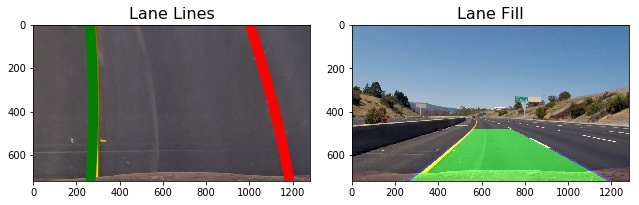

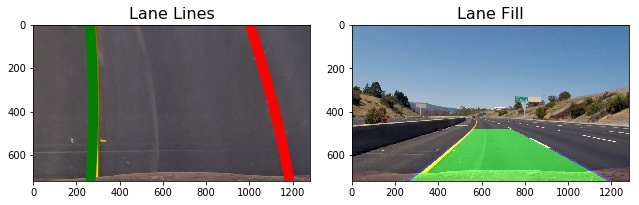

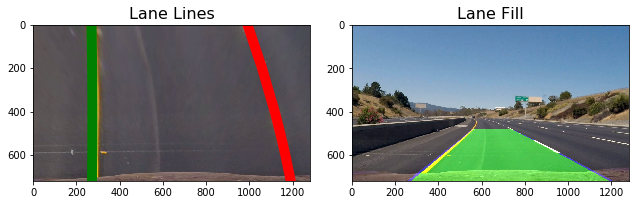

In [70]:
# debug with video images
test_files = ['dbg_frame_101.jpg', 'dbg_frame_102.jpg', 'dbg_frame_103.jpg' ]
for image in test_files:
    img1 = cv2.imread(image)
    warped = apply_transforms(img1)
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    #plot3(img1, 'original', warped, 'warped image', histogram, 'histogram' )
    fill_lane(img1)